## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys, shutil
from os.path import abspath, dirname, basename
from glob import glob
import numpy as np
import pandas as pd
import warnings
import joblib
from tqdm import tqdm

import dcor

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# import toybrains
TOUYBRAINS_REPO = os.path.abspath("../../")
if TOUYBRAINS_REPO not in sys.path: sys.path.append(TOUYBRAINS_REPO)

from utils.DLutils import *
from utils.vizutils import *

In [4]:
DEEPREPVIZ_BACKEND = abspath( "../../../Deep-confound-control-v2/application/backend/deep_confound_control/core/")
assert os.path.isdir(DEEPREPVIZ_BACKEND) and os.path.exists(DEEPREPVIZ_BACKEND+'/DeepRepVizBackend.py'), f"No DeepRepViz repository found in {DEEPREPVIZ_BACKEND}. Add the correct relative path to the backend to the 'DEEPREPVIZ_BACKEND' global variable."
if DEEPREPVIZ_BACKEND not in sys.path:
    sys.path.append(DEEPREPVIZ_BACKEND)
from DeepRepVizBackend import DeepRepVizBackend

In [5]:
N_SAMPLES = 5000
EXP_NAME = 'lblmidr-consite'

## Compute all metrics (DL-act-based $A_{conf}$ scores)

```bash
! python3 run-deeprepvizbackend.py
```
with correct configurations set inside the `run-deeprepvizbackend.py` file

## Load computed logdirs

In [6]:
# select the model runs for which we want to compare the results
cy = '0*'
cX = '0*'
yX = '0*'
logdirs = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if 'debug' not in log]
        )))

print("Collected n={} model logs:".format(len(logdirs)))

# drop log folders that are not complete
logdirs = [logdir for logdir in logdirs if len(glob(f"{logdir}/*/deeprepvizlog/DeepRepViz-v1*"))==len(glob(f"{logdir}/*/deeprepvizlog/"))]
print("after dropping incomplete logs n={} logs are still remaining".format(len(logdirs)))
logdirs

Collected n=11 model logs:
after dropping incomplete logs n=11 logs are still remaining


['log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX075_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX075_SimpleCNN_c1-f032',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX075_SimpleCNN_c1-f256']

In [7]:
# parallelize the loading of the logs
def process_drvlogdir(deeprepvizlogdir, verbose=1):
    if verbose==1: print("loading from:", deeprepvizlogdir)

    iter_version = basename(dirname(deeprepvizlogdir))
    if verbose==1: print("loading run version:", iter_version)
    # ignore the missing conf_table warning from DeepRepVizBackend
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Provided conf_table")
        drv_backend = DeepRepVizBackend(best_ckpt_by='loss_test')
    drv_backend.load_log(deeprepvizlogdir)

    log = drv_backend.deeprepvizlogs[deeprepvizlogdir]
    ckpt_idx = log['best_ckpt_idx']
    ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
    logdirname = deeprepvizlogdir.split('/')[-3]
    dataset = logdirname.split('_')[3]
    model_name = logdirname.replace(dataset, '').split('__')[-1]
    if verbose==2:
        print(f"{'='*100}\n {model_name} :: \n\t setting: {dataset} ")
        print(f"\t at ckpt: {ckptname} (idx={ckpt_idx}) \n\t ckpt contains: {list(log_ckpt.keys())}")
        print("\t Model accuracy : {}".format({k:f'{v*100:.2f}%' for k,v in log_ckpt['metrics'].items()}))
        
    result = {("Model",k): v for k,v in log_ckpt['metrics'].items()}
    if 'act_metrics' not in log_ckpt:
        print(f"[ERROR] Metrics not computed for {logdirname}/{iter_version} at ckpt={ckptname} (idx={ckpt_idx}). Skipping...")
        
    else:
        for metric_name, metric_scores in log_ckpt['act_metrics'].items():
            if verbose==2: print(f"\t {'-'*10} \t Metric = {metric_name} \t {'-'*30}")
            for key in ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']:
                if verbose: print("\t {} \t=\t {:.4f}".format(key, metric_scores[key]))
                result.update({(key, metric_name): metric_scores[key]})

    return (dataset, model_name, iter_version), result, drv_backend

## Print computed logdirs & metrics

In [8]:
# collect the DeepRepViz backend results in a dict
def collect_deeprepviz_results(logdirs, verbose=1, n_jobs=-1):

    # for each logdir extract the list of all runs
    logdirs_runs = []
    for logdir in logdirs:
        logdirs_runs.extend(sorted(glob(f"{logdir}/*/deeprepvizlog")))

    all_results_drvs = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(process_drvlogdir)(drvlogdir, verbose) for drvlogdir in tqdm(logdirs_runs))
    
    if len(all_results_drvs)==0:
        print("[ERROR] No results were loaded. Exiting...")
        return None
    
    all_results = {keys: results for keys, results, _ in all_results_drvs}
    
    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    df_results.index = df_results.index.set_names(['dataset', 'model_name', 'trial'])
    # first sort by model name, then by data setting and finally by trial
    df_results = df_results.sort_index(level='trial').sort_index(level='dataset',
                                       key=lambda x: x.str[-3:].astype(int)*10 + (x.str[2:5].astype(int) * x.str[8:11].astype(int))/2)
    # sort the columns by model name and then by metric name
    df_results = df_results.sort_index(axis=1, level=[0,1])
    
    return df_results


#################################################################################################################
df_results = collect_deeprepviz_results(logdirs, verbose=0, n_jobs=-1)

  0%|          | 0/33 [00:00<?, ?it/s]

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested

[ERROR] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_2 at ckpt=epoch05-step000120 (idx=5). Skipping...
[ERROR] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f032/trial_1 at ckpt=epoch08-step000180 (idx=8). Skipping...
[ERROR] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_0 at ckpt=epoch25-step000520 (idx=25). Skipping...
[ERROR] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_1 at ckpt=epoch30-step000620 (idx=30). Skipping...
[ERROR] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f032/trial_2 at ckpt=epoch06-step000140 (idx=6). Skipping...
[ERROR] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f032/trial_0 at ckpt=epoch36-step000740 (idx=36). Skipping...
[ERROR] Metrics not computed for toybrains_n5000_lblmid

In [9]:
print("loaded {} rows with {} models, {} unique datasets per model with upto {} trials per dataset.".format(len(df_results), 
                                            (df_results.index.get_level_values('model_name').nunique()), 
                                            (df_results.index.get_level_values('dataset').nunique()), 
                                            (df_results.index.get_level_values('trial').nunique())))

# show the table
df_results.style.bar(vmin=0, vmax=1)

loaded 33 rows with 3 models, 4 unique datasets per model with upto 3 trials per dataset.


See average values across trials

In [10]:
df_results.reset_index().groupby(['model_name', 'dataset']).mean(numeric_only=True).style.bar(vmin=0, vmax=1)

dropping on a non-lexsorted multi-index without a level parameter may impact performance.


### Plot the results

In [12]:
# def plot_deeprepviz_results(df_results, 
#                             filter = '',
#                             norm_metrics = '', #'dcor|mi|con|r2',
#                             ylim = None):
#     # drop the indexes 'model_name' and 'trial' and only keep the 'data_setting' as index
#     df = df_results.copy().reset_index(level=['model_name', 'trial'])
#     for feas, dfi in df.groupby('model_name'):
#         # drop the loss
#         loss_cols = dfi.columns[dfi.columns.get_level_values(1).str.contains('loss')].values.tolist() 

#         dfi = dfi.drop(columns=[('model_name', ''),('trial', ''), *loss_cols])
#         # flatten the multi-index columns
#         dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
#         # drop the costeta columns and additional user-defined filters
#         dfi = dfi.filter(regex='^(?!.*costeta)')
#         # sort the index by 10*(X<-y) + (X<-c * c->y)/2
#         dfi = dfi.sort_index(lambda x: 
#                              int(x.str[-3:])*10 + (int(x.str[2:5]) * int(x.str[8:11]))/2)
    
#         # sort the columns alphabetically
#         dfi = dfi.reindex(sorted(dfi.columns), axis=1)
        
#         # normalize the metrics requested
#         if norm_metrics != '':
#             metric_cols = dfi.columns.str.contains(norm_metrics)
#             dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
#             lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)
    
#         # apply 
#         if filter != '':
#             dfi = dfi.filter(regex=filter)
#         assert dfi.shape[0] > 0, f"No columns remained after applying the filter: {filter}"

#         # plot the results
#         fig, ax = plt.subplots(figsize=(16, 6))
#         g = sns.lineplot(dfi, err_style="bars", ax=ax)
#         sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncols=4)
        
#         ax.set_title(f"DL model settings: {feas.split('_')}")
#         if ylim is not None or norm_metrics!='':
#             ax.set_ylim(ylim)

#         # on the x-axis ticks show the total X<-y and the total X<-c->y
#         new_xticklabels = []
#         majorticks = [-1]
#         last_Xy = -1
#         last_Xcy = -1
#         for lbl in ax.get_xticklabels():
#             cy, cX, yX  = lbl.get_text().split('-')
#             cy = int(cy[-1])
#             cX = int(cX[-1])
#             yX = int(yX[-1])
#             total_Xy = 100*(yX)/4
#             total_Xcy = 100*(cX*cy)/16
#             # add a major tick label every time the total_Xy changes
#             if total_Xcy - last_Xcy >= 95:
#                 majorticks.append(lbl.get_position()[0])

#             if total_Xy != last_Xy:
#                 new_xticklabels.append(f'Xy={total_Xy:3.0f}%      {total_Xcy:3.0f}%')
#                 last_Xy = total_Xy
#             else:
#                 new_xticklabels.append(f'{total_Xcy:3.0f}%')
        
#         ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)
#         # vertical lines to show transition of X<-c->y
#         for x_line in majorticks:
#             ax.axvline(x_line, color='grey', ls='--', lw=0.8, alpha=0.5)
#             ax.vlines(x_line, 0, -0.25, color='grey', ls='--', lw=0.8,
#                     clip_on=False,
#                     transform=ax.get_xaxis_transform())
#         # ax.set_xlim(-1, majorticks[-1]+1)
#         ax.set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]'+'\n'+r'   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    
#         plt.show()


# #############################################################################################################
# plot_deeprepviz_results(df_results, filter='Model.*', 
#                         norm_metrics='', ylim=(0,1))

## New metrics: CCA / PCA / ICA

In [13]:
logdir_runs =sorted([l for logdir in logdirs for l in glob(f"{logdir}/*/deeprepvizlog")])
logdir_runs

['log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_0/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_1/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_2/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_0/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_1/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_2/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_0/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_1/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_2/deeprepvizlog',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f032/trial_0/deeprepvizlog',
 'log/toybrains_n500

### Load activations $H^{(l-1)}$ for all trials

In [14]:
# load the activation at the resp. best checkpoints of the model
logs = []
for logdir_run in logdir_runs:
    (dataset, model_name, run), _, drv = process_drvlogdir(logdir_run, verbose=0)
    log = drv.deeprepvizlogs[logdir_run]
    act = log['checkpoints'][log['best_ckpt_idx']][1]['acts']
    test_acc = log['checkpoints'][log['best_ckpt_idx']][1]['metrics']['BAC_test']
    logs.append((dataset, model_name, run, {
        'best_ckpt_idx': log['best_ckpt_idx'],
        'IDs': log['IDs'],
        'y': log['labels'].astype(float),
        'y_pred': log['checkpoints'][log['best_ckpt_idx']][1]['preds_0'].astype(float),
        'test_acc': test_acc,
        'act': act,
    }))
    print(f"activation loaded from {logdir_run} with shape {act.shape}")

activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_0/deeprepvizlog with shape (5000, 32)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_1/deeprepvizlog with shape (5000, 32)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f032/trial_2/deeprepvizlog with shape (5000, 32)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_0/deeprepvizlog with shape (5000, 256)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_1/deeprepvizlog with shape (5000, 256)
activation loaded from log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256/trial_2/deeprepvizlog with shape (5000, 256)
[ERROR] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_0 at ckpt=epoch25-step000520 (idx=25). Skipping...
activ

In [15]:
unique_models = sorted(set([model for _, model, _, _ in logs]))
unique_datasets = sorted(set([dataset for dataset, _, _, _ in logs]))

#### Datasets distributions

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy000-cX000-yX000


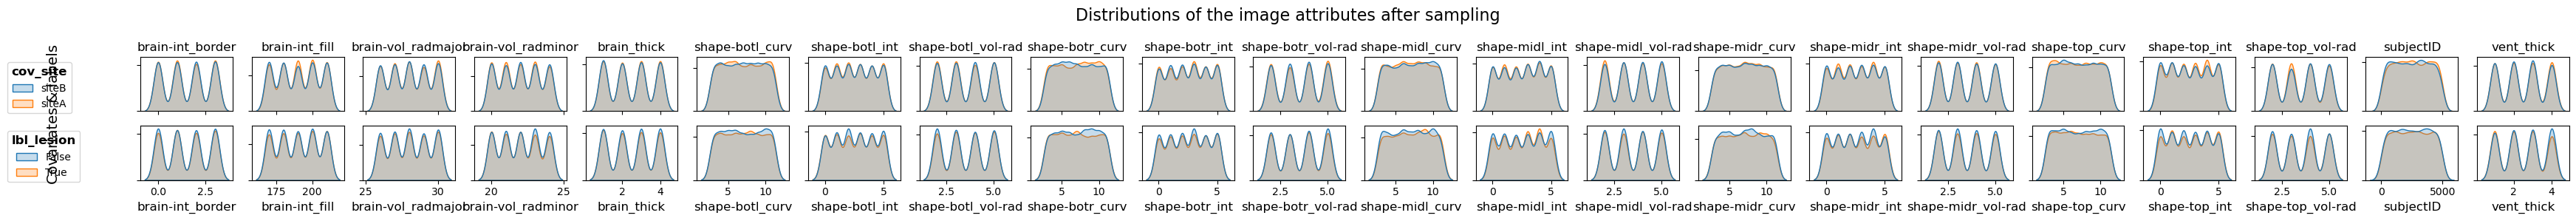

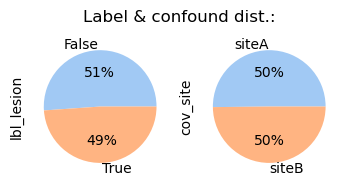

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy000-cX000-yX075


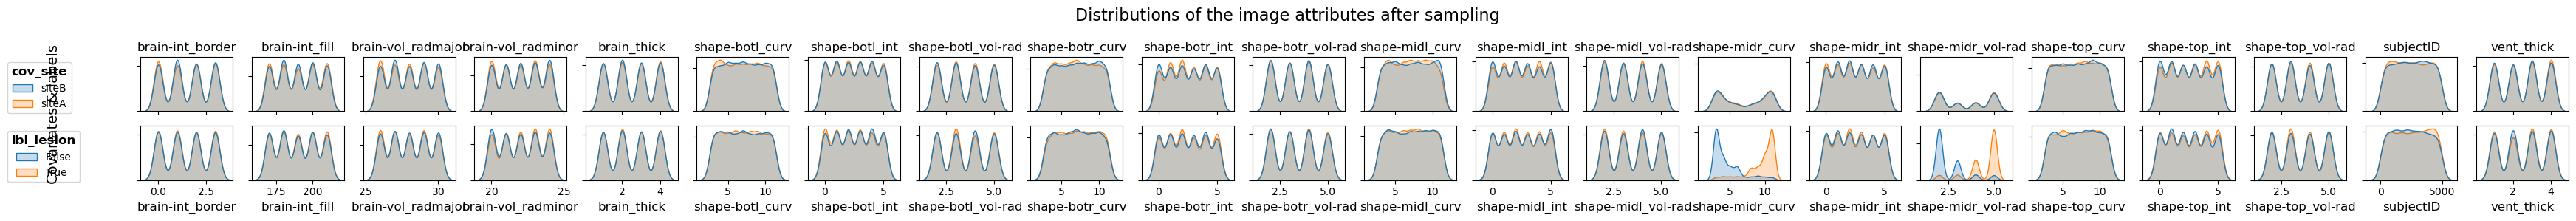

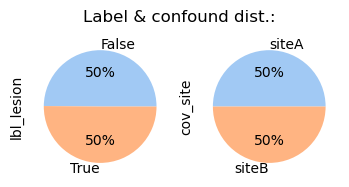

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy075-cX075-yX000


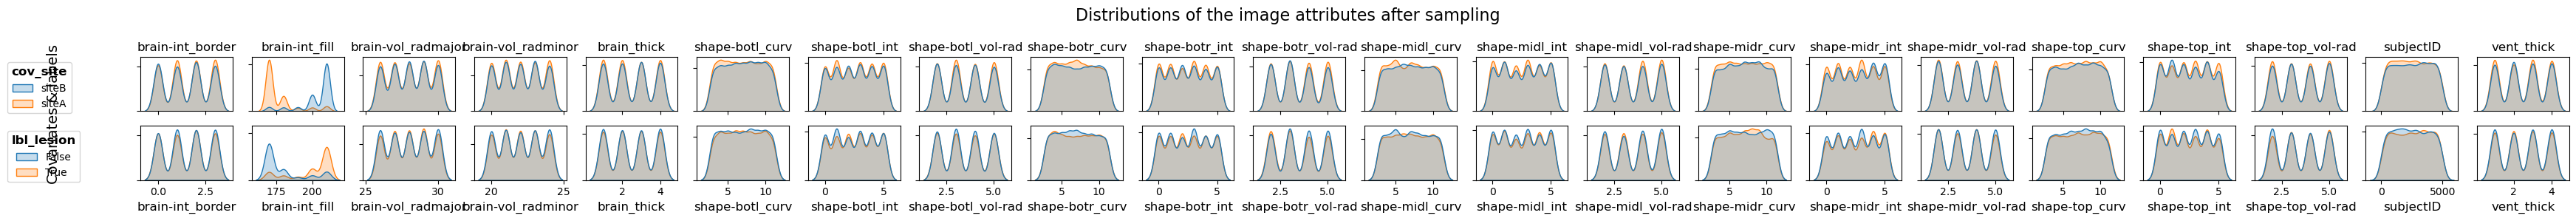

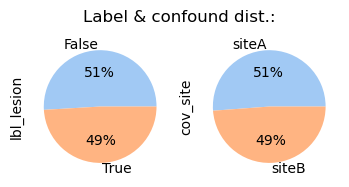

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: cy075-cX075-yX075


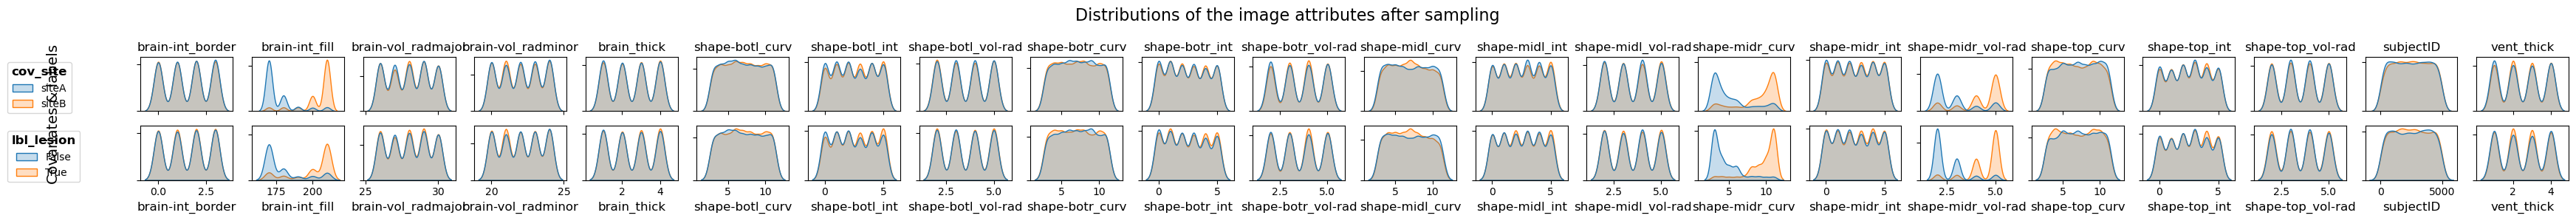

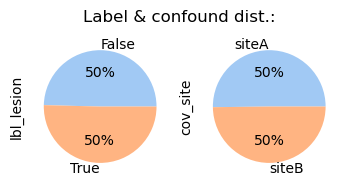

In [16]:
from utils.vizutils import plot_col_dists, plot_col_counts, show_images

show_images=False

for dataset_cy_cx_yx in unique_datasets:
    
    dataset_log = 'Dataset: '+ dataset_cy_cx_yx
    print('--'*80, '\n', dataset_log)
    dataset_name = f'dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset_cy_cx_yx}'
    df = pd.read_csv(f'{dataset_name}/{os.path.basename(dataset_name)}.csv') 
    # drop the volumes(_vol) as radius (_rad) already captures this info
    df = df.drop(columns=df.columns[df.columns.str.contains('vol') & ~(df.columns.str.contains('rad'))])

    ### (1) show the image attributes distributions
    cov_cols = df.filter(regex='^(cov_|lbl_)').columns
    attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
    plot_col_dists(df, 
                attr_cols=attr_cols, 
                cov_cols=cov_cols, 
                title=f"Distributions of the image attributes after sampling")
    plt.show()

    ### (2) show the label and confounder distributions
    plot_col_counts(df[cov_cols], title="Label & confound dist.:")
    plt.show()

    ### (3) show the correlation between the conf and labels
    drv = DeepRepVizBackend(conf_table=df, 
                        ID_col='subjectID', label_col='lbl_lesion', 
                        best_ckpt_by="test_loss")
    
    corr = drv.df_conf.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    display(corr
    .style
    .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
    .highlight_null(color='#f1f1f1')  # Color NaNs grey
    .format(precision=2))

    ### (3) show sample images for different combinations of the conf and label states
    if show_images:
        n_imgs_per_row = 15
        # show 4 rows of images with different combinations of covariate and label states
        # df = pd.read_csv(f'{dataset}/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}.csv')
        for (lbl, cov), dfi in df.groupby(['lbl_lesion', 'cov_site']):
            # sample n_imgs_per_row 
            samples = dfi.sample(n_imgs_per_row, replace=False, random_state=None).index.values
            img_files = [f"{dataset_name}/images/{s:05}.jpg" for s in samples]
            # print(lbl, cov, img_files)
            show_images(img_files=img_files,
                        n_cols=n_imgs_per_row, n_rows=1,
                        title=f"{dataset_log}      |      lbl_lesion={lbl}      |       cov_site={cov}      |")
            plt.show()

### $\frac{dCor(\hat{y},c)}{dCor(y,c)}$

In [17]:
def compute_dcor_sq(X, y):
    if len(X.shape)>1: 
        y = y.reshape(-1,1)
    assert X.shape[0]==y.shape[0], f"the shape of the activations and covariates should be (N, D) and (N, 1)\
 respectively but they are {X.shape} and {y.shape} respectively"
    dcor_score = float(dcor.distance_correlation_sqr(X, y))
    return dcor_score**2

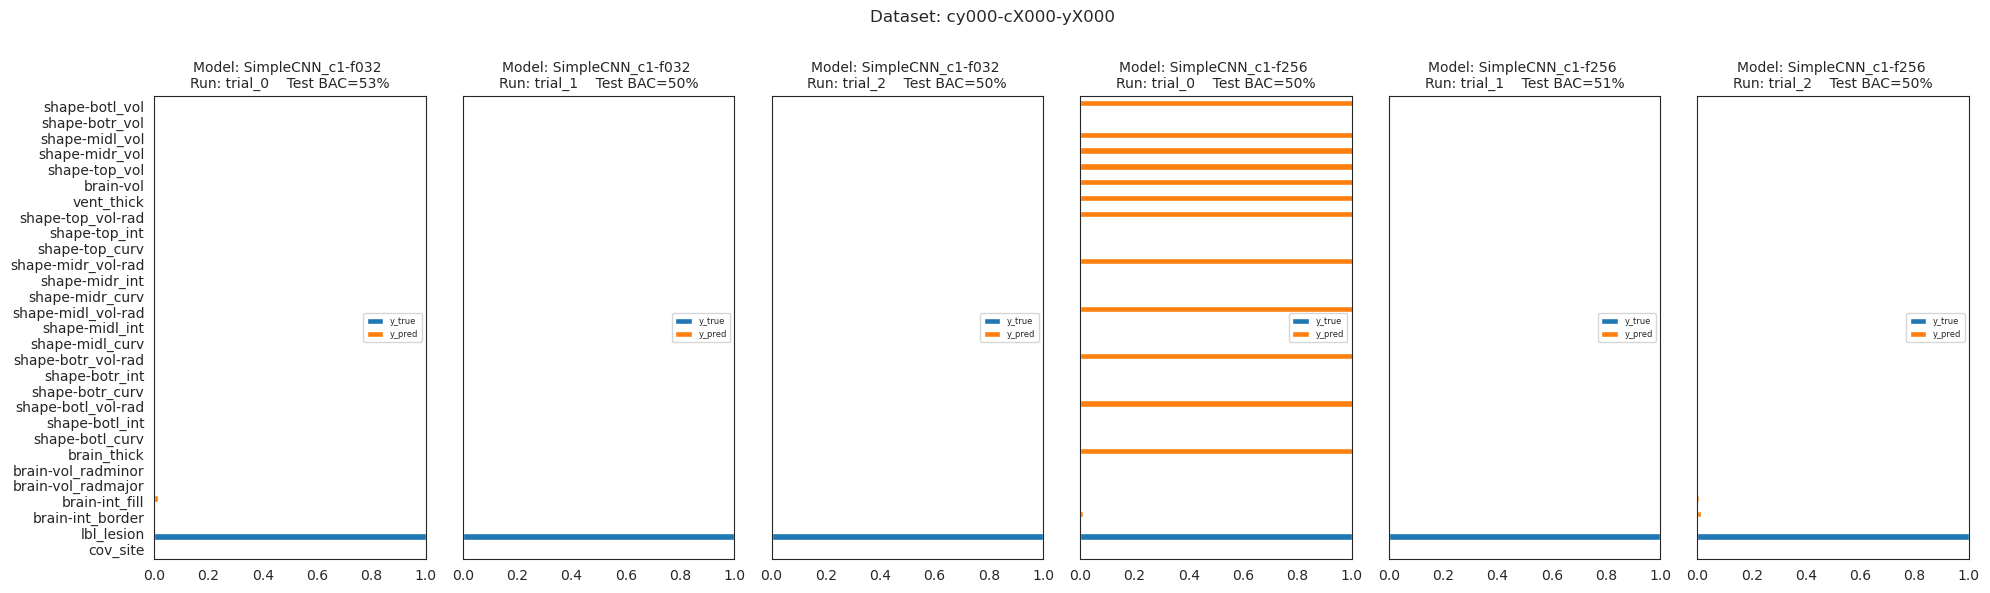

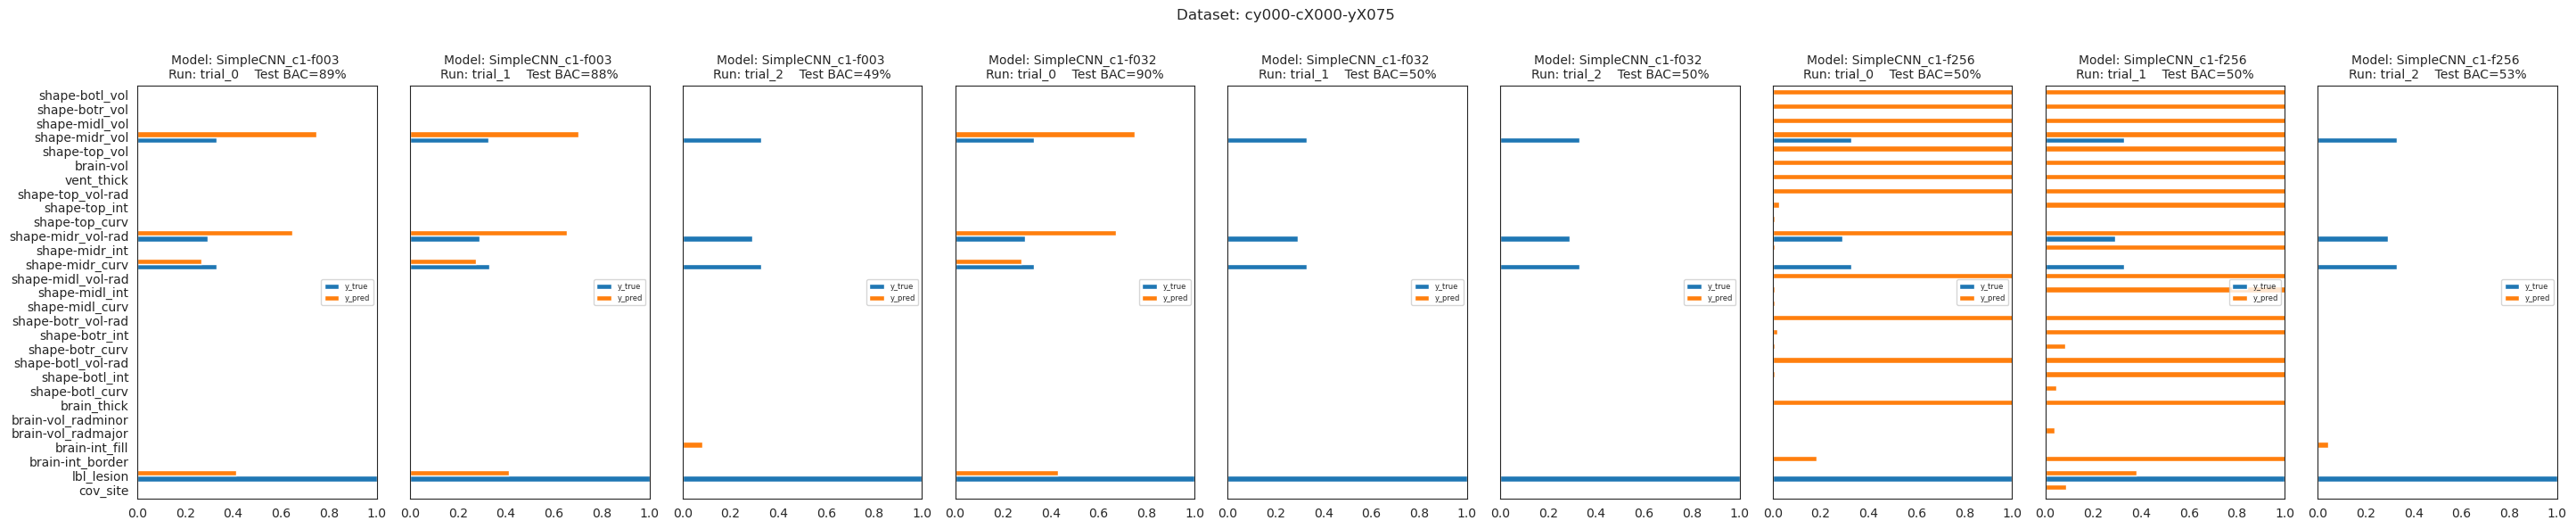

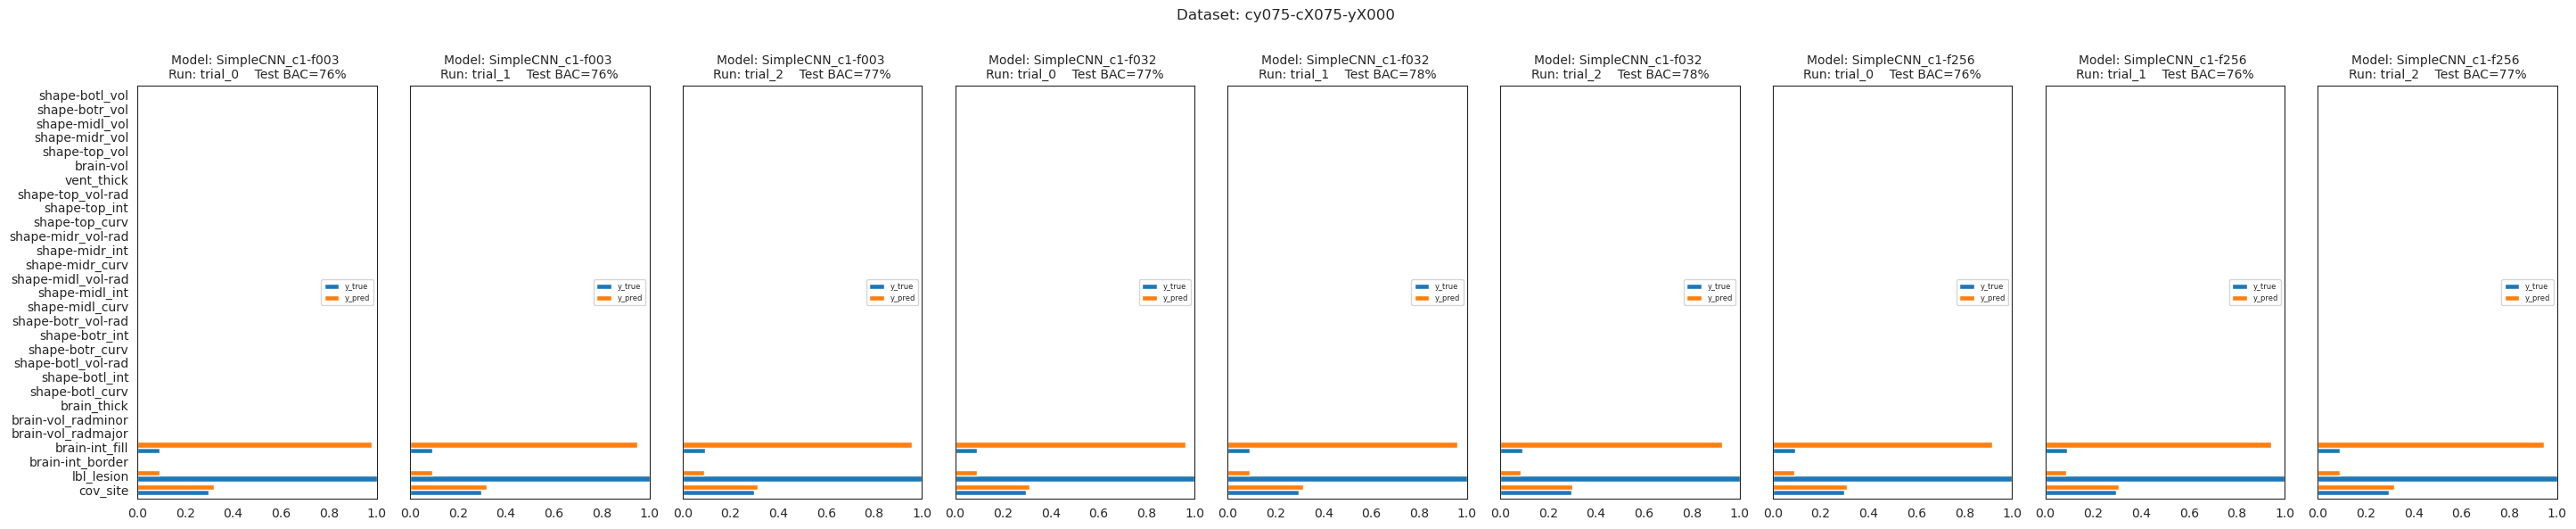

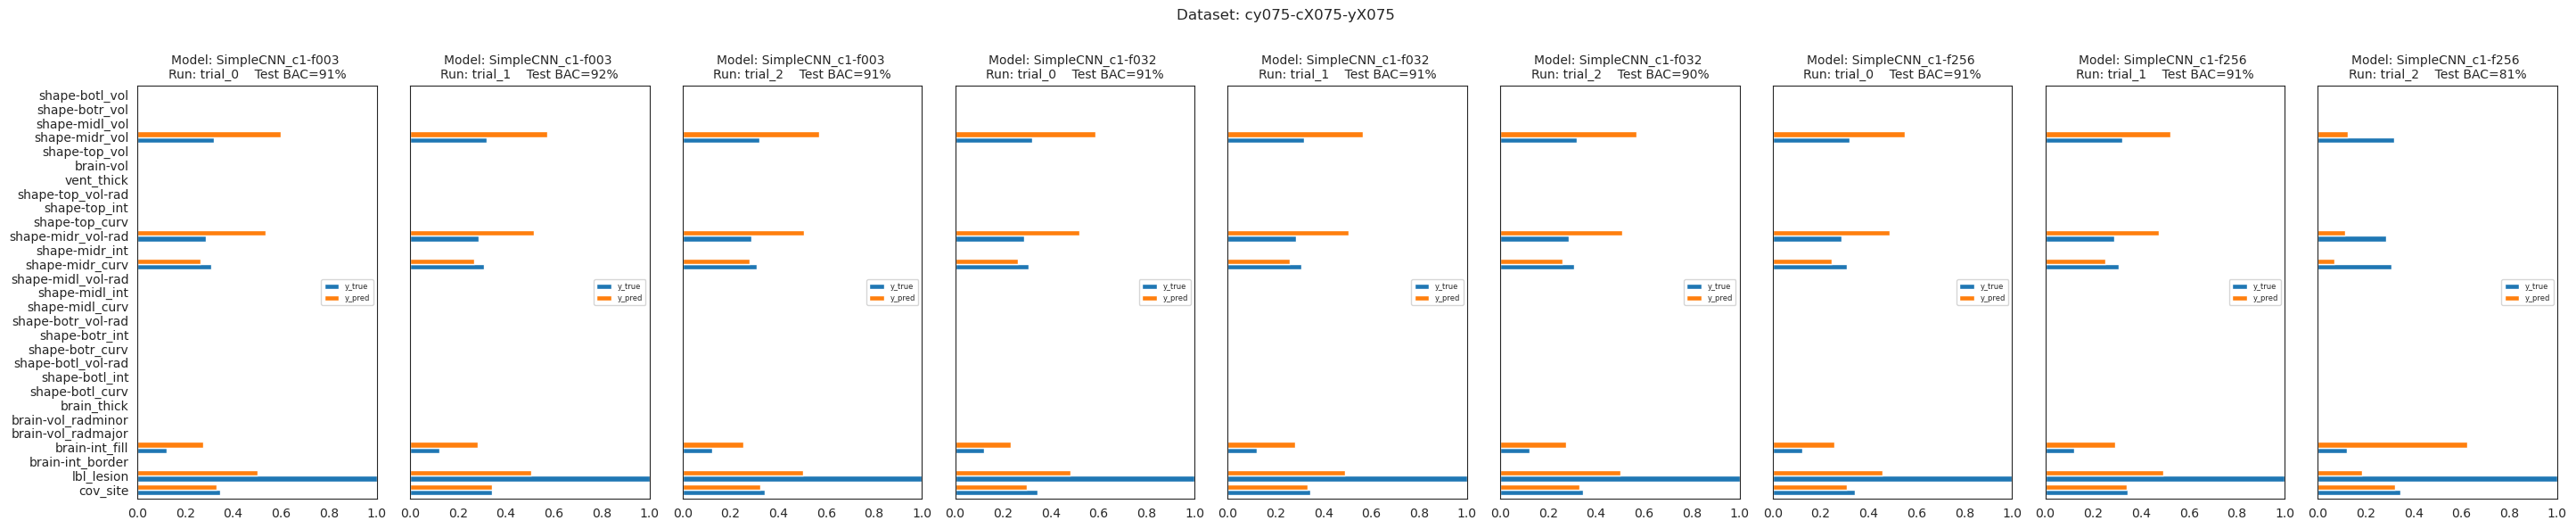

In [18]:
sns.set_style("white")
N_COMPONENTS = 3 


for dataset in unique_datasets:

    logs_subset = [log for log in logs if (log[0]==dataset)]
    if len(logs_subset)==0: continue

    fig, axes = plt.subplots(1, len(logs_subset), 
                            sharex=True, sharey=True, 
                            figsize=(2+3*len(logs_subset), 6))
    axes = axes.flatten()
    fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
        # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

        # (1) load the confounds table
        df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
        # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

        # make the table values numerical using the DeepRepVizBackend
        drv = DeepRepVizBackend(conf_table=df_attrs, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
        df_attrs = drv.df_conf
        # reorder to match the IDs of the model results and the confound table
        df_attrs = df_attrs.loc[log['IDs']]

        # (2) select the subset of covariates to compute the metrics
        conf_subset =  df_attrs.columns  # ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        
        # (3) Compute the metric and populate it in a table
        df_scores = pd.DataFrame(index=['y_true','y_pred'], columns=conf_subset)

        assert np.all(log['IDs'] == df_attrs.index.values), "IDs do not match between the confound table and the model results."
        for y_name, y in [('y_true', log['y']), ('y_pred', log['y_pred'])]:
            for conf in conf_subset:
                conf_var = df_attrs[conf].values
                df_scores.at[y_name, conf] = compute_dcor_sq(y.astype(float), conf_var.astype(float))


        df_scores.T.plot.barh(ax=ax, width=0.8)
        ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
        ax.legend(loc='center right', prop={'size': 6})
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

### PCA ($H^{(l-1)}, c$)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def compute_pca(X, n_components=0.9):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply PCA and print the list of PC components that explain 90% of the variance
    pca = PCA(n_components=n_components)
    X_ica = pca.fit_transform(X)
    return X_ica, pca

invalid value encountered in divide


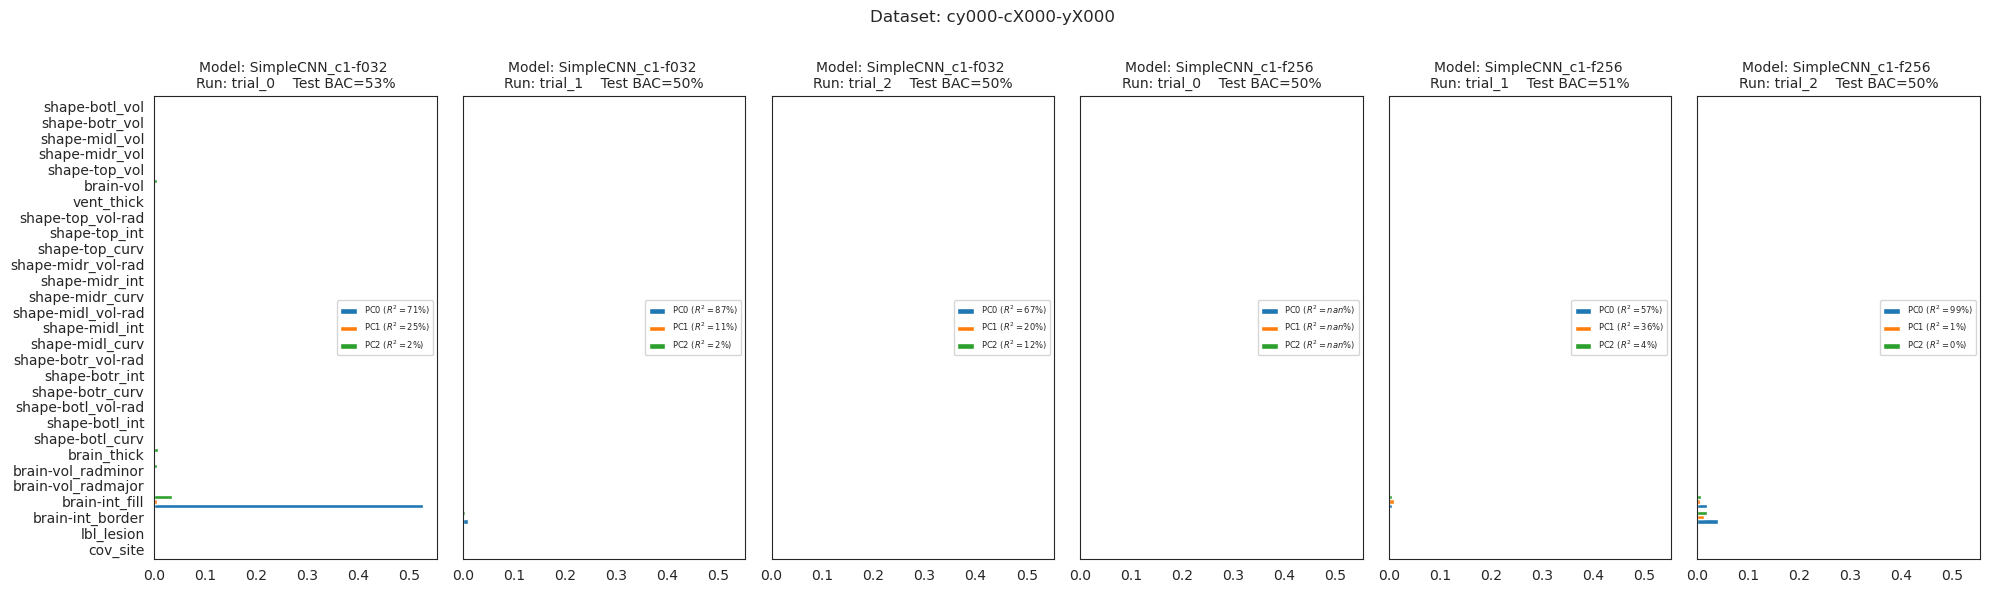

invalid value encountered in divide
invalid value encountered in divide


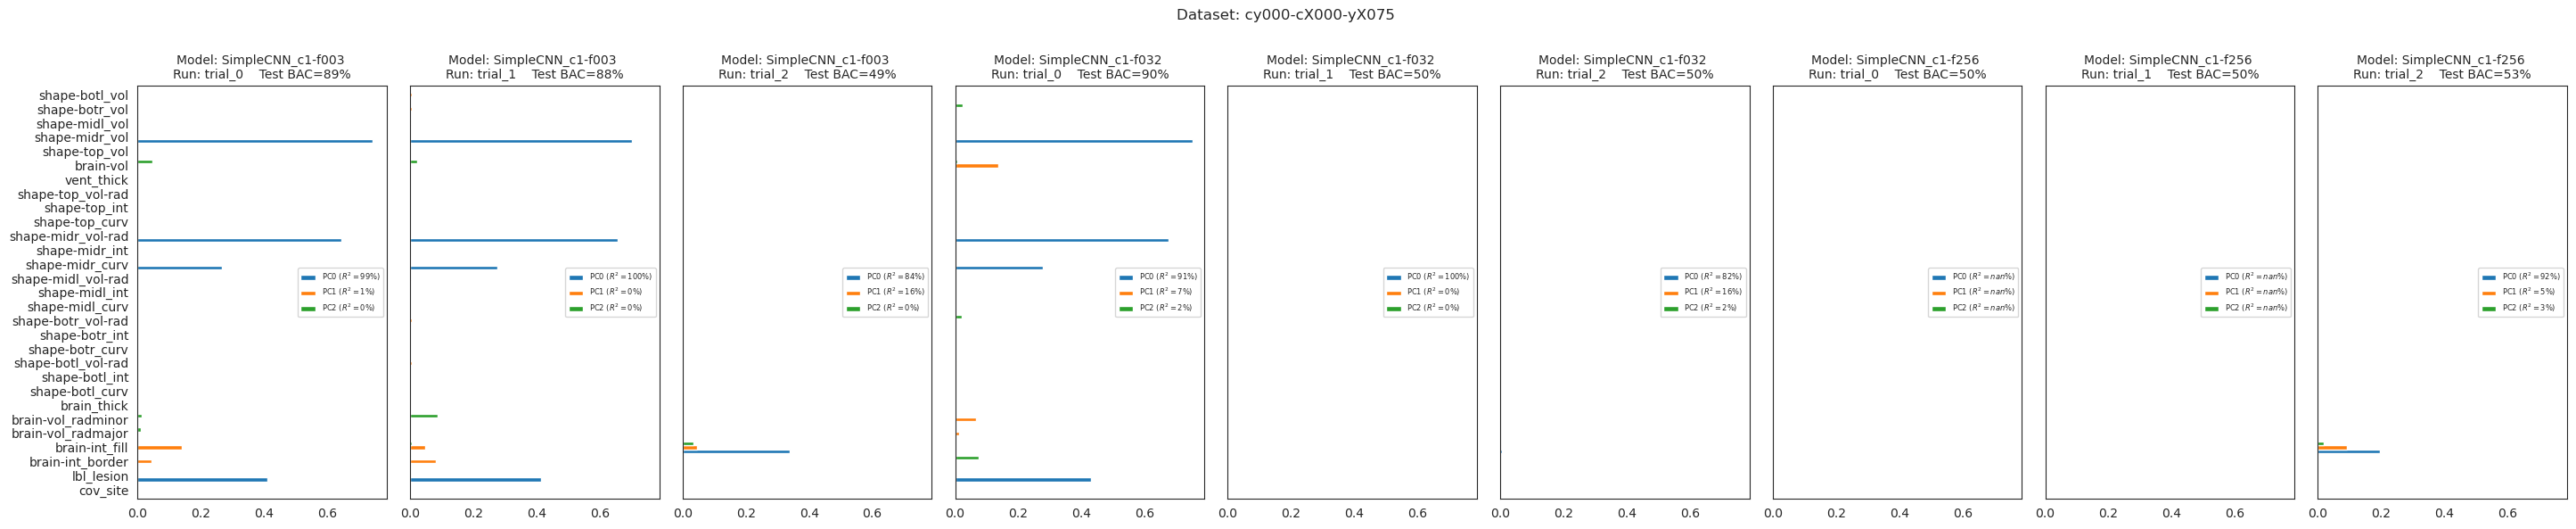

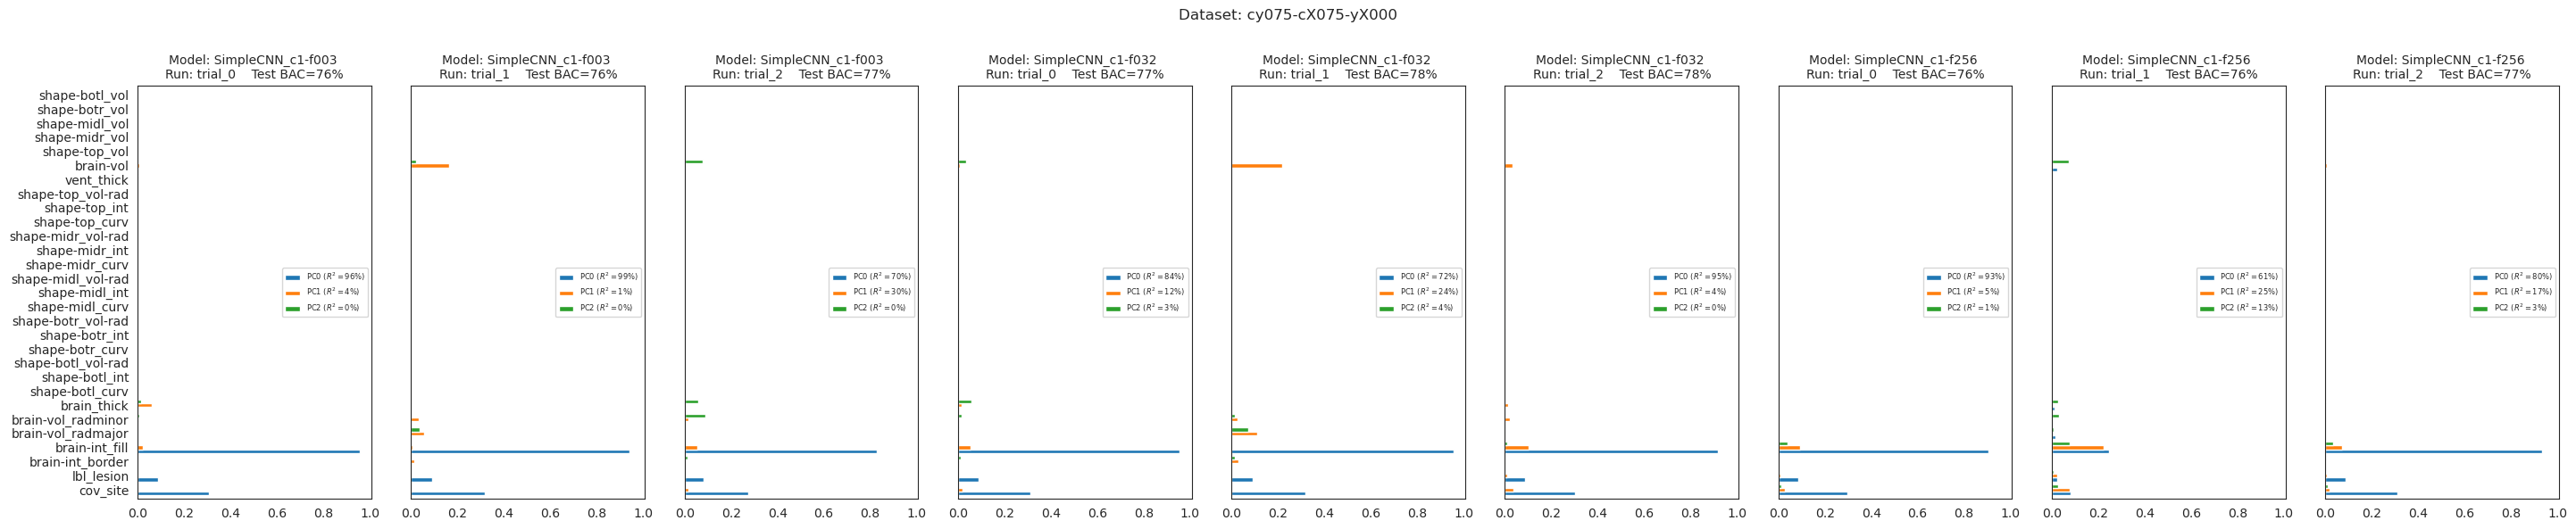

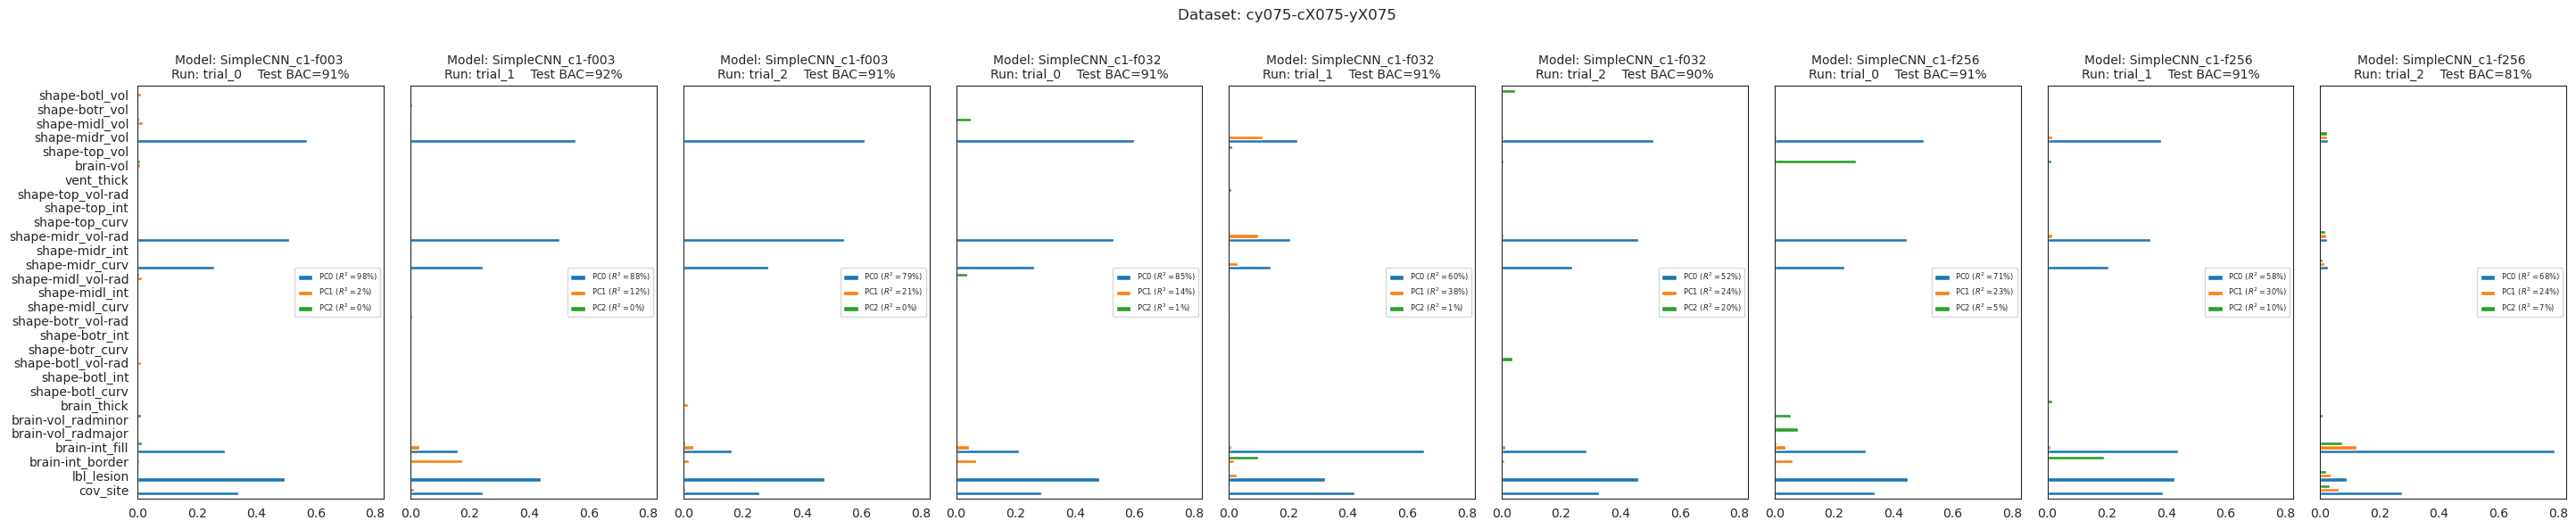

In [20]:
sns.set_style("white")
N_COMPONENTS = 3 


for dataset in unique_datasets:

    logs_subset = [log for log in logs if (log[0]==dataset)]
    if len(logs_subset)==0: continue

    fig, axes = plt.subplots(1, len(logs_subset), 
                            sharex=True, sharey=True, 
                            figsize=(2+3*len(logs_subset), 6))
    axes = axes.flatten()
    fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

        # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

        # (1) load the confounds table
        df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
        # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

        # make the table values numerical using the DeepRepVizBackend
        drv = DeepRepVizBackend(conf_table=df_attrs, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
        df_attrs = drv.df_conf
        # reorder to match the IDs of the model results and the confound table
        df_attrs = df_attrs.loc[log['IDs']]
        
        # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")
        X_pca, pca = compute_pca(log['act'], n_components=N_COMPONENTS)
        # for 5 variables in the metadata table compute the correlation with the top PCs
        conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        df_scores = pd.DataFrame(index=[f"PC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

        for i in range(N_COMPONENTS):
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                df_scores.at[f"PC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

        # add the explained variance of each PC in the legend info
        def append_r2(pc):
            i = int(pc.replace('PC', ''))
            return "PC{} ($R^2={:.0f}$%)".format(i, pca.explained_variance_ratio_[i]*100)
        df_scores.index = pd.Series(df_scores.index).apply(append_r2)
        # print("Number of components with 90% variance: ", pca.n_components_)
        # print("Eigen values: ", pca.explained_variance_)

        df_scores.T.plot.barh(ax=ax, width=0.8)
        ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
        ax.legend(loc='center right', prop={'size': 6})
        # ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

### Apply ICA

> ICA is an algorithm that finds directions in the feature space corresponding to projections with high non-Gaussianity. These directions need not be orthogonal in the original feature space, but they are orthogonal in the whitened feature space, in which all directions correspond to the same variance.
PCA, on the other hand, finds orthogonal directions in the raw feature space that correspond to directions accounting for maximum variance.

In [21]:
from sklearn.decomposition import FastICA

def compute_ica(X, n_components=0.9):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    ica = FastICA(n_components=n_components)
    X_ica = ica.fit_transform(X) 
    
    return X_ica, ica



divide by zero encountered in divide
invalid value encountered in divide


[ERROR] ICA failed to converge for SimpleCNN_c1-f256 on cy000-cX000-yX000 at run trial_0. Skipping...


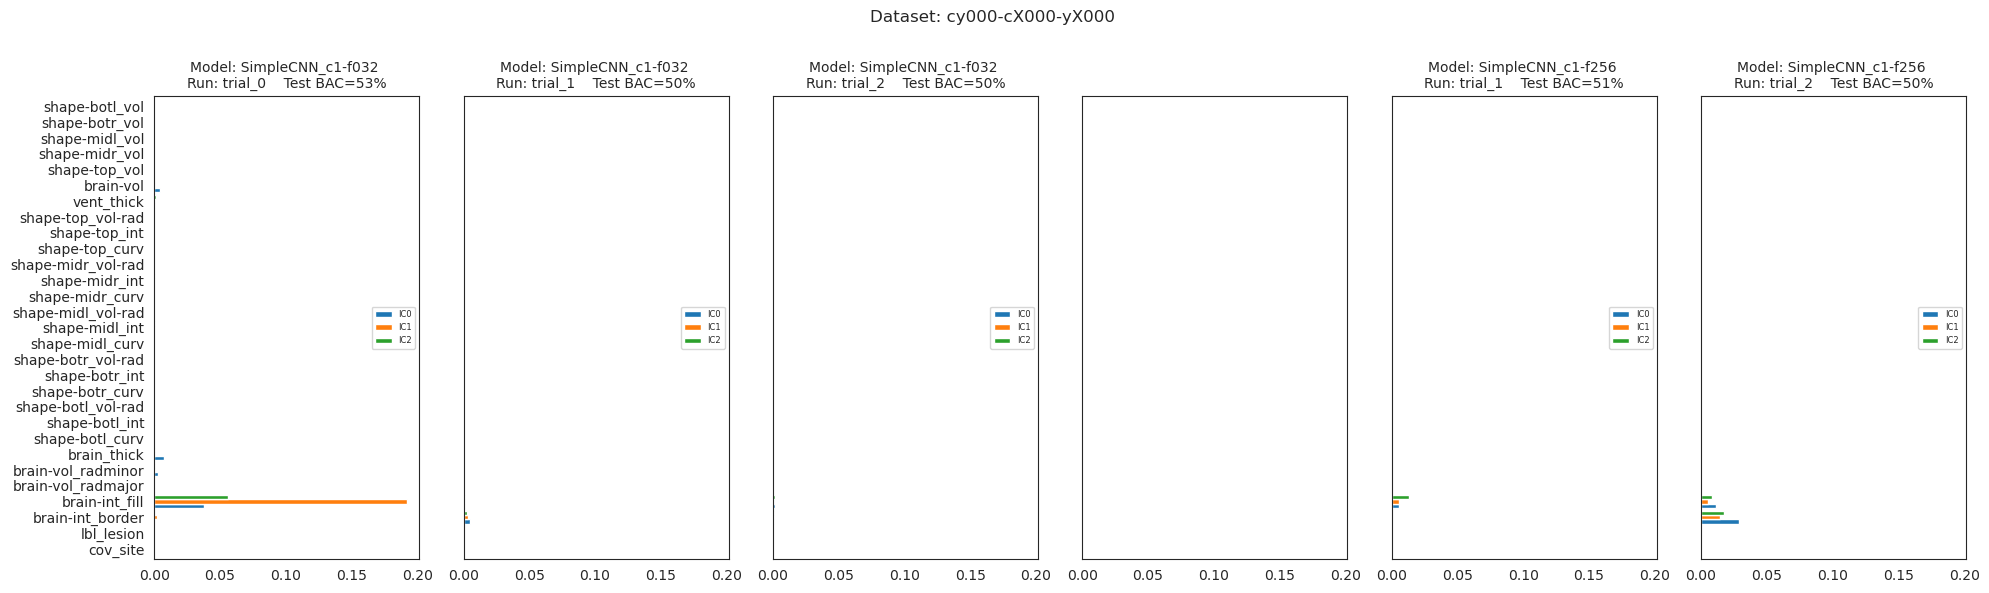

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
divide by zero encountered in divide
invalid value encountered in divide


[ERROR] ICA failed to converge for SimpleCNN_c1-f256 on cy000-cX000-yX075 at run trial_0. Skipping...


divide by zero encountered in divide
invalid value encountered in divide


[ERROR] ICA failed to converge for SimpleCNN_c1-f256 on cy000-cX000-yX075 at run trial_1. Skipping...


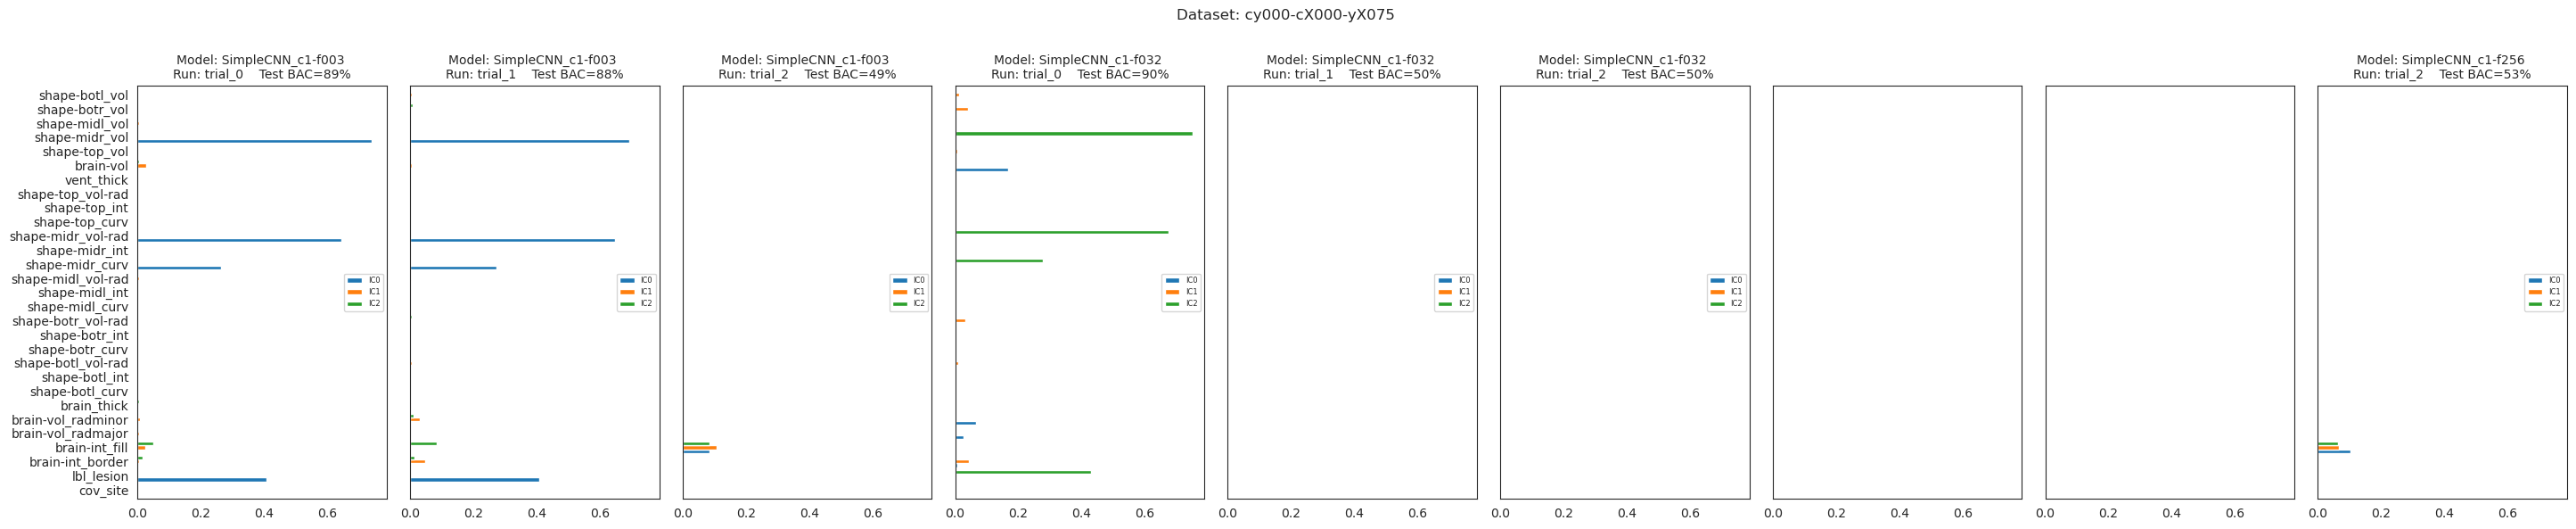

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


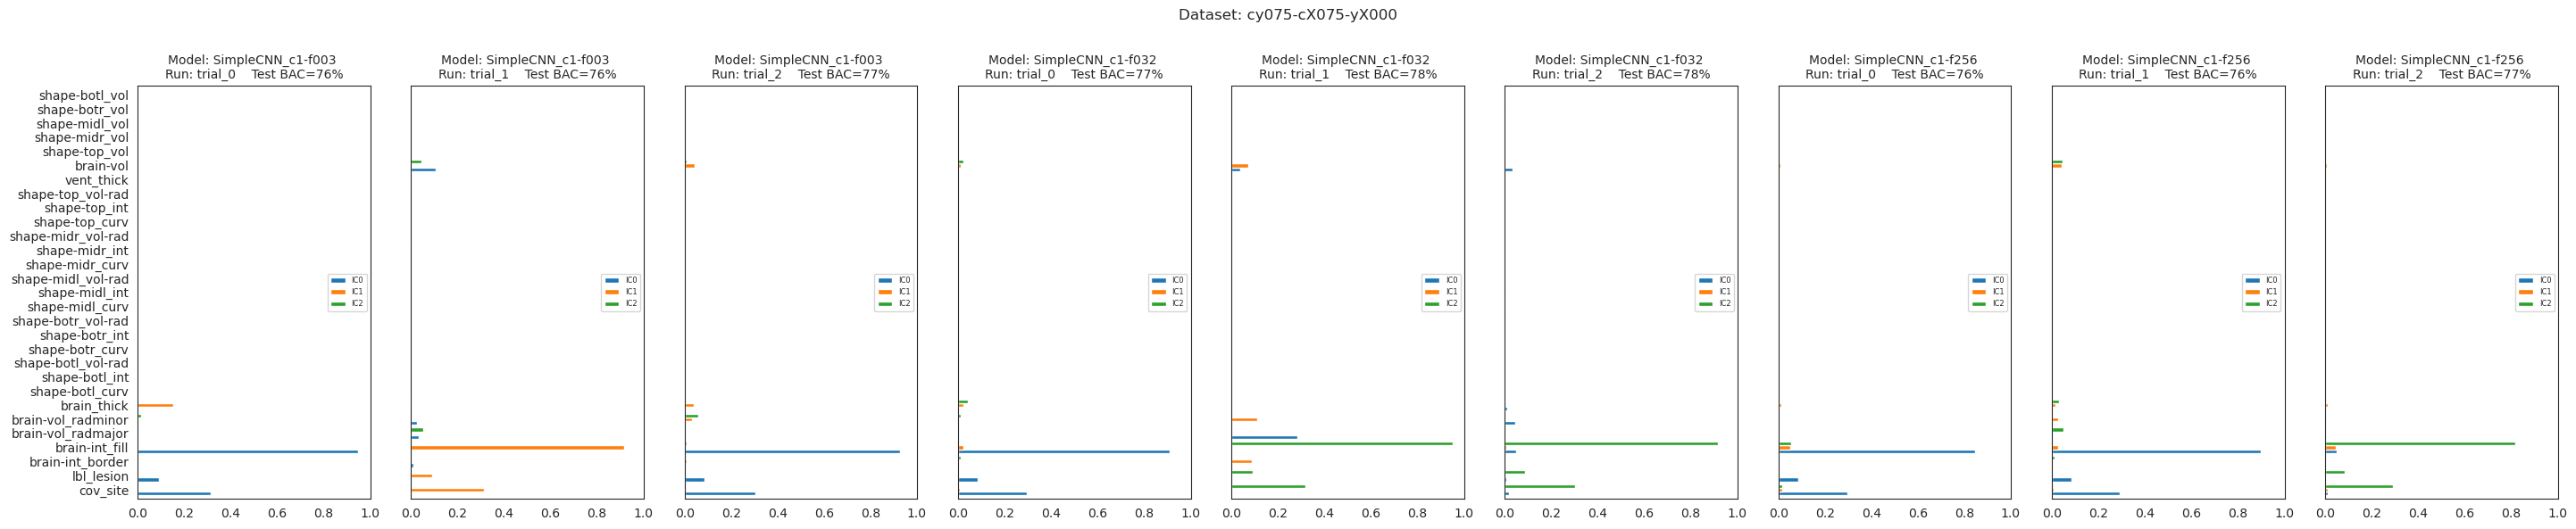

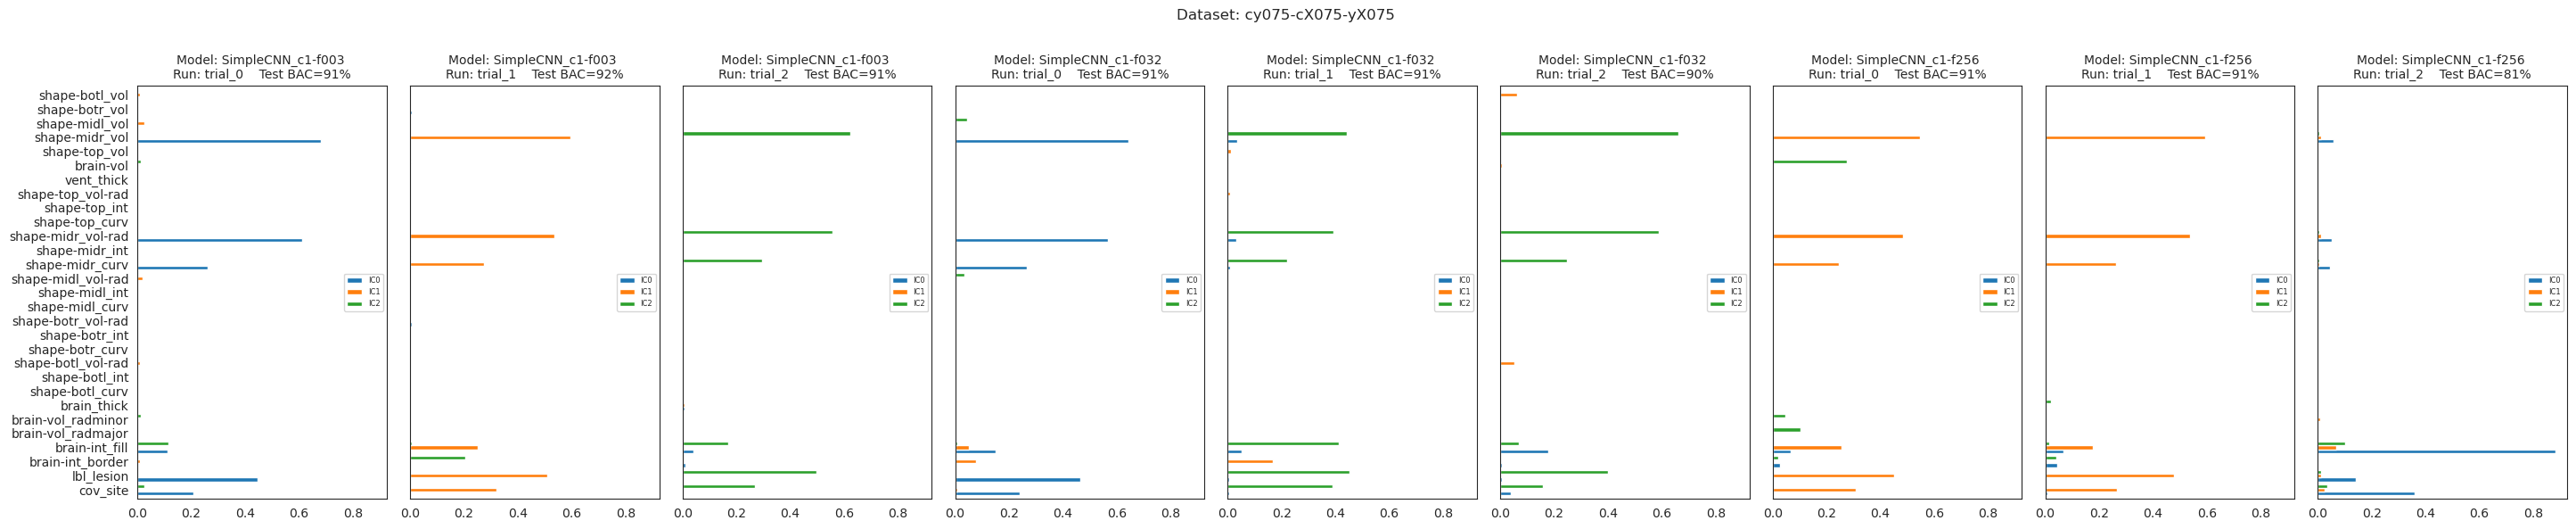

In [22]:
sns.set_style("white")

N_COMPONENTS=3

for dataset in unique_datasets:

    logs_subset = [log for log in logs if (log[0]==dataset)]
    fig, axes = plt.subplots(1, len(logs_subset), 
                            sharex=True, sharey=True, 
                            figsize=(2+3*len(logs_subset), 6))
    axes = axes.flatten()
    fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
        # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

        # (1) load the confounds table
        df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
        # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

        # make the table values numerical using the DeepRepVizBackend
        drv = DeepRepVizBackend(conf_table=df_attrs, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
        df_attrs = drv.df_conf
        # reorder to match the IDs of the model results and the confound table
        df_attrs = df_attrs.loc[log['IDs']]
        try:
            X_pca, pca = compute_ica(log['act'], n_components=N_COMPONENTS)
        except:
            print(f"[ERROR] ICA failed to converge for {model_name} on {dataset} at run {run}. Skipping...")
            continue
        # for 5 variables in the metadata table compute the correlation with the top PCs
        conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        df_scores = pd.DataFrame(index=[f"IC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

        for i in range(N_COMPONENTS):
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                df_scores.at[f"IC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

        df_scores.T.plot.barh(ax=ax, width=0.8)
        ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
        ax.legend(loc='center right', prop={'size': 6})

    plt.tight_layout()
    plt.show()

### LDA

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def compute_lda(X, y):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y) 
    X_lda = lda.transform(X)
    
    return X_lda, lda


[ERROR] LDA failed to converge for SimpleCNN_c1-f256 on cy000-cX000-yX000 at run trial_0. Skipping... 
Internal work array size computation failed: -10

Intel MKL ERROR: Parameter 10 was incorrect on entry to DGESDD.


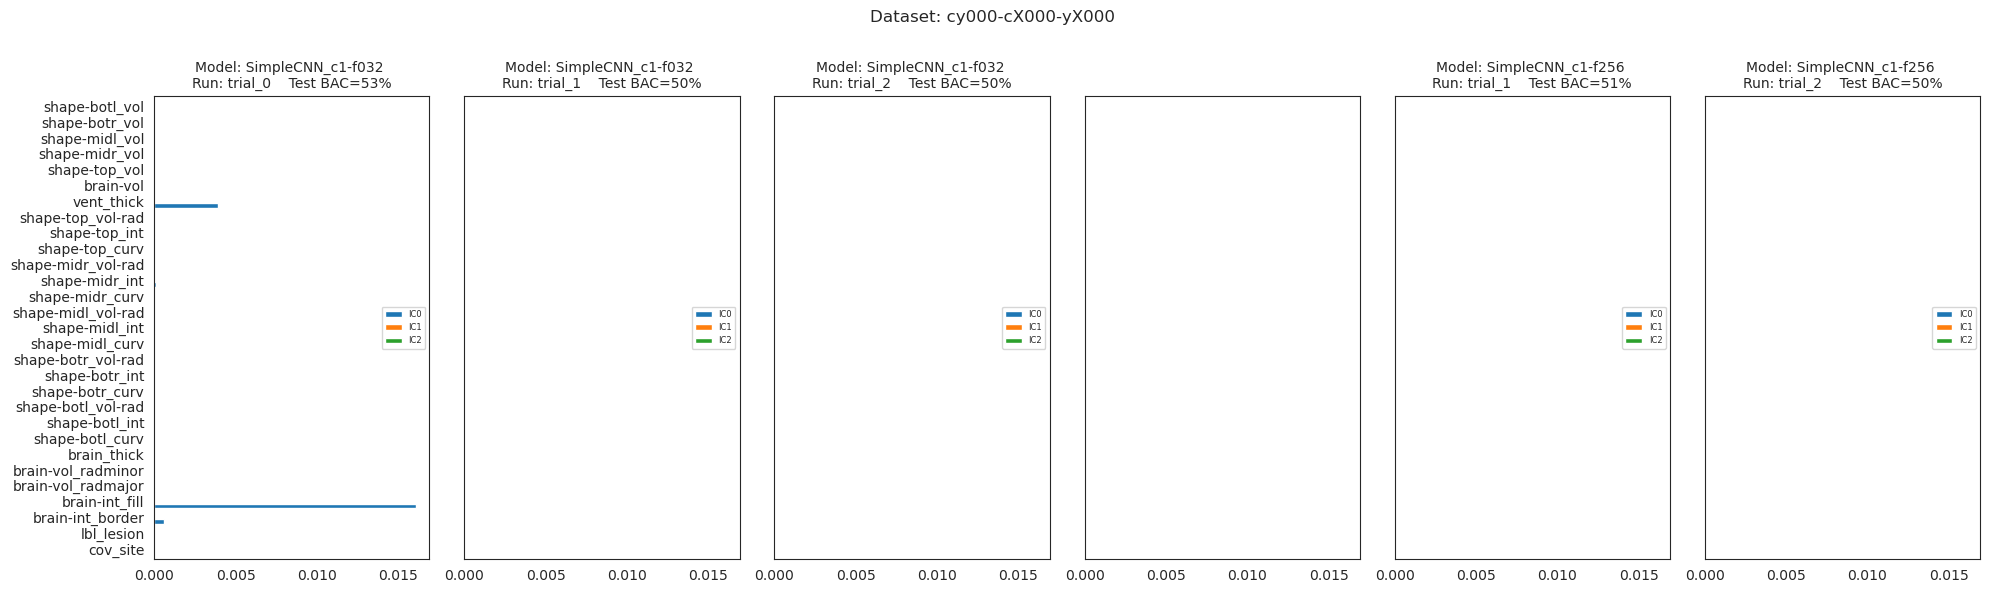

[ERROR] LDA failed to converge for SimpleCNN_c1-f256 on cy000-cX000-yX075 at run trial_0. Skipping... 
Internal work array size computation failed: -10
Intel MKL ERROR: Parameter 10 was incorrect on entry to DGESDD.

[ERROR] LDA failed to converge for SimpleCNN_c1-f256 on cy000-cX000-yX075 at run trial_1. Skipping... 
Internal work array size computation failed: -10
Intel MKL ERROR: Parameter 10 was incorrect on entry to DGESDD.



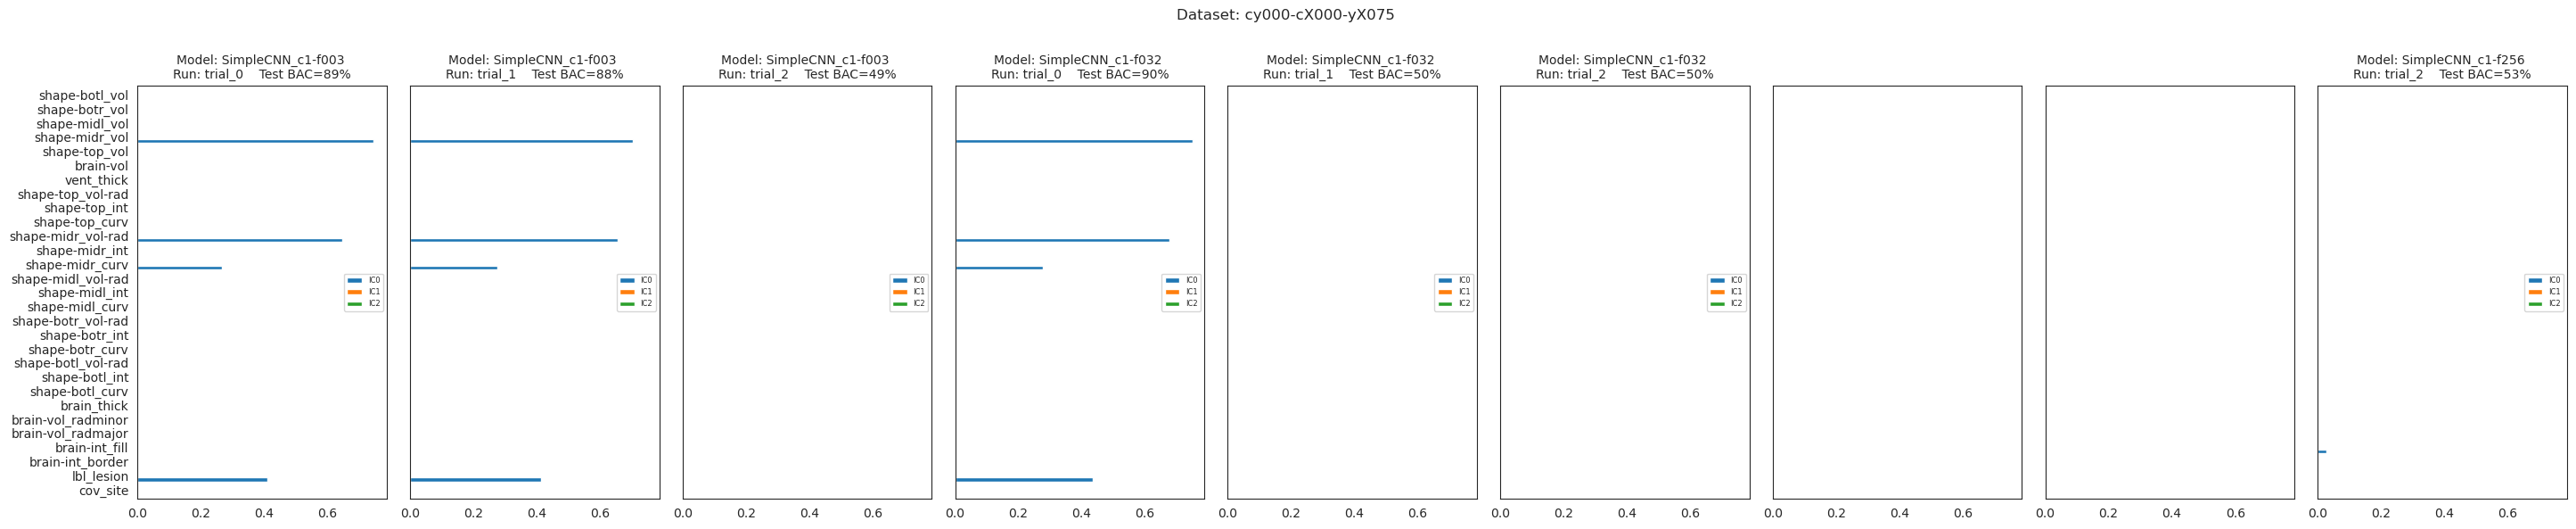

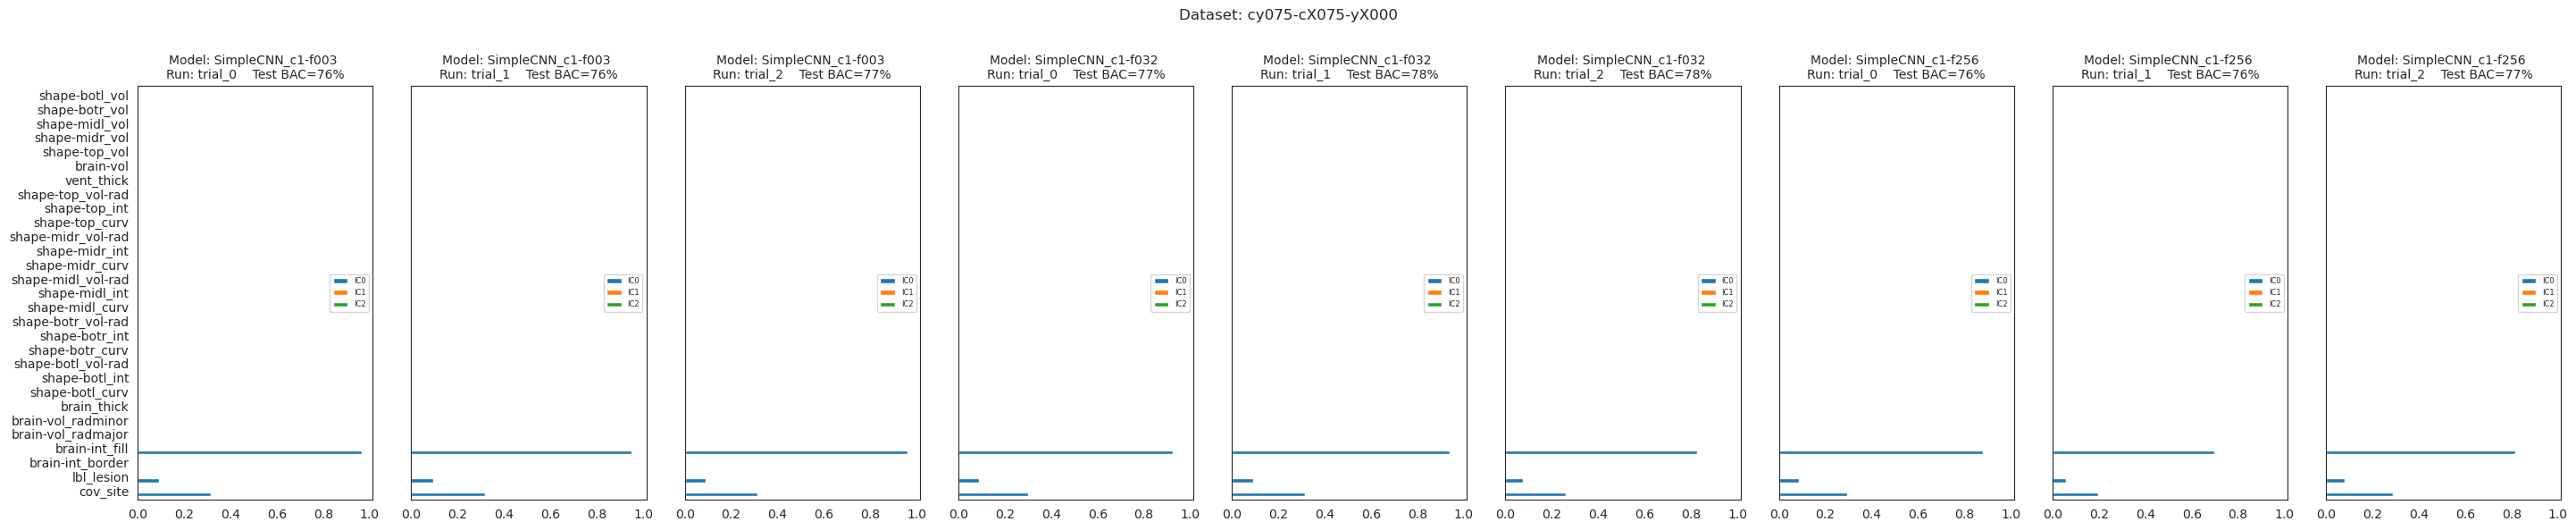

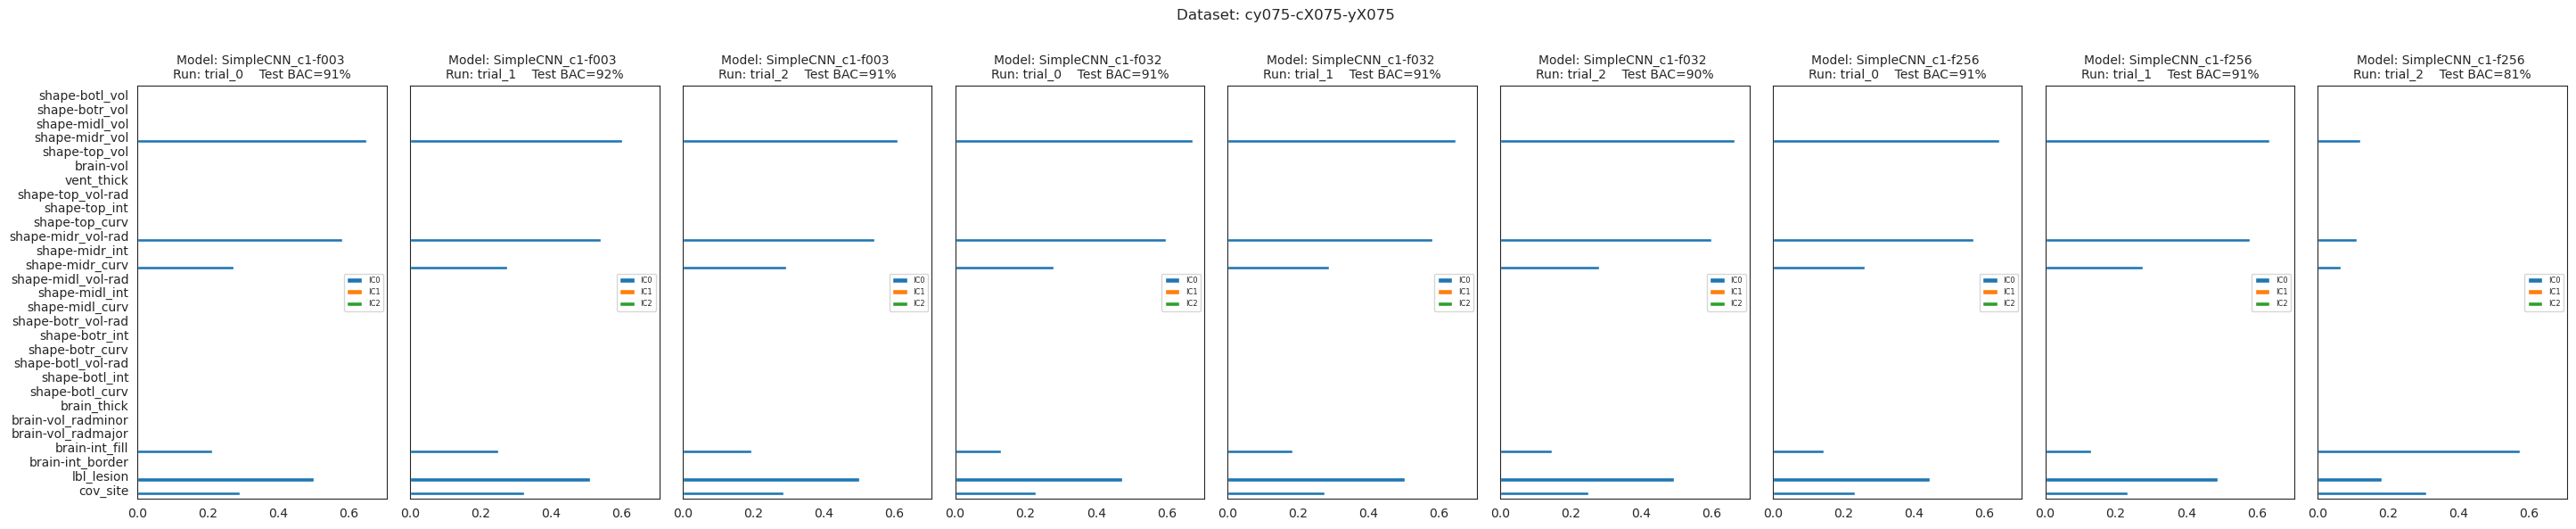

In [26]:
sns.set_style("white")

N_COMPONENTS=3

for dataset in unique_datasets:

    logs_subset = [log for log in logs if (log[0]==dataset)]
    fig, axes = plt.subplots(1, len(logs_subset), 
                            sharex=True, sharey=True, 
                            figsize=(2+3*len(logs_subset), 6))
    axes = axes.flatten()
    fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

        # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

        # (1) load the confounds table
        df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
        # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

        # make the table values numerical using the DeepRepVizBackend
        drv = DeepRepVizBackend(conf_table=df_attrs, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
        df_attrs = drv.df_conf
        # reorder to match the IDs of the model results and the confound table
        df_attrs = df_attrs.loc[log['IDs']]

        try:
            X_pca, pca = compute_lda(log['act'], (log['y_pred']>0.5))
        except Exception as e:
            print(f"[ERROR] LDA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
            continue
        
        # for 5 variables in the metadata table compute the metric
        conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        df_scores = pd.DataFrame(index=[f"IC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

        for i in range(X_pca.shape[-1]):
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                df_scores.at[f"IC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

        df_scores.T.plot.barh(ax=ax, width=0.8)
        ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
        ax.legend(loc='center right', prop={'size': 6})

    plt.tight_layout()
    plt.show()

### Viz act-based scores

In [ ]:
def plot_deeprepviz_results(df_results, 
                            filter = '',
                            norm_metrics = '', #'dcor|mi|con|r2',
                            ylim = None):
    # drop the indexes 'model_name' and 'trial' and only keep the 'data_setting' as index
    df = df_results.copy().reset_index(level=['model_name', 'trial'])
    for feas, dfi in df.groupby('model_name'):
        # drop the loss
        loss_cols = dfi.columns[dfi.columns.get_level_values(1).str.contains('loss')].values.tolist() 

        dfi = dfi.drop(columns=[('model_name', ''),('trial', ''), *loss_cols])
        # flatten the multi-index columns
        dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
        # drop the costeta columns and additional user-defined filters
        dfi = dfi.filter(regex='^(?!.*costeta)')
        # sort the index by 10*(X<-y) + (X<-c * c->y)/2
        dfi = dfi.sort_index(key=lambda x: x.str[-1].astype(int)*10 + (x.str[2].astype(int) * x.str[6].astype(int))/2)
    
        # sort the columns alphabetically
        dfi = dfi.reindex(sorted(dfi.columns), axis=1)
        
        # normalize the metrics requested
        if norm_metrics != '':
            metric_cols = dfi.columns.str.contains(norm_metrics)
            dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
            lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)
    
        # apply 
        if filter != '':
            dfi = dfi.filter(regex=filter)
        assert dfi.shape[0] > 0, f"No columns remained after applying the filter: {filter}"

        # plot the results
        fig, ax = plt.subplots(figsize=(16, 6))
        g = sns.lineplot(dfi, err_style="bars", ax=ax)
        sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncols=4)
        
        ax.set_title(f"DL model settings: {feas.split('_')}")
        if ylim is not None or norm_metrics!='':
            ax.set_ylim(ylim)

        # on the x-axis ticks show the total X<-y and the total X<-c->y
        new_xticklabels = []
        majorticks = [-1]
        last_Xy = -1
        last_Xcy = -1
        for lbl in ax.get_xticklabels():
            cy, cX, yX  = lbl.get_text().split('-')
            cy = int(cy[-1])
            cX = int(cX[-1])
            yX = int(yX[-1])
            total_Xy = 100*(yX)/4
            total_Xcy = 100*(cX*cy)/16
            # add a major tick label every time the total_Xy changes
            if total_Xcy - last_Xcy >= 95:
                majorticks.append(lbl.get_position()[0])

            if total_Xy != last_Xy:
                new_xticklabels.append(f'Xy={total_Xy:3.0f}%      {total_Xcy:3.0f}%')
                last_Xy = total_Xy
            else:
                new_xticklabels.append(f'{total_Xcy:3.0f}%')
        
        ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)
        # vertical lines to show transition of X<-c->y
        for x_line in majorticks:
            ax.axvline(x_line, color='grey', ls='--', lw=0.8, alpha=0.5)
            ax.vlines(x_line, 0, -0.25, color='grey', ls='--', lw=0.8,
                    clip_on=False,
                    transform=ax.get_xaxis_transform())
        # ax.set_xlim(-1, majorticks[-1]+1)
        ax.set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]'+'\n'+r'   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    
        plt.show()


Model performance 

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


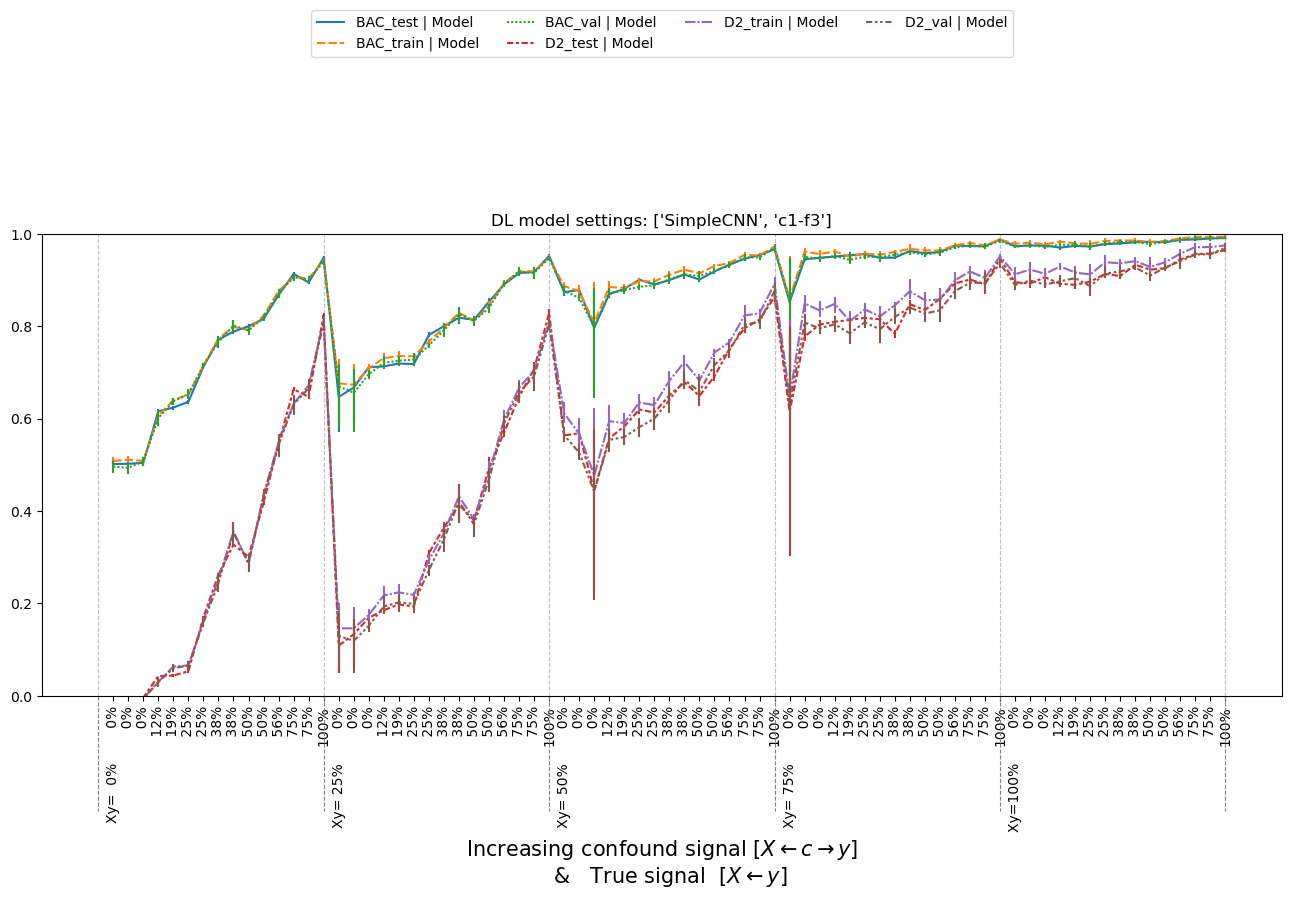

In [ ]:
plot_deeprepviz_results(df_results, filter='Model.*', 
                        norm_metrics='', ylim=(0,1))

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


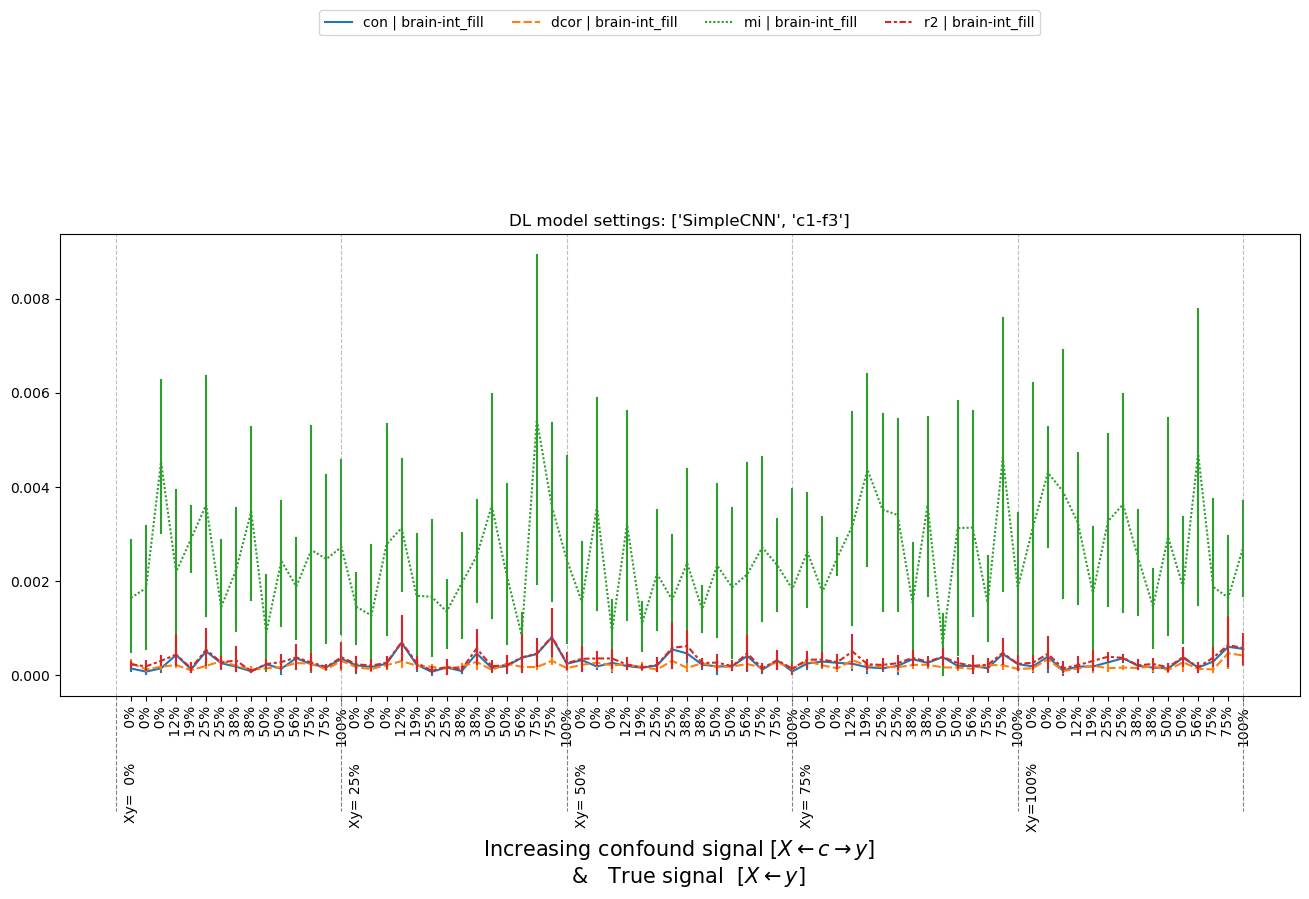

In [ ]:
plot_deeprepviz_results(df_results, filter="(brain-int_fill)")

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


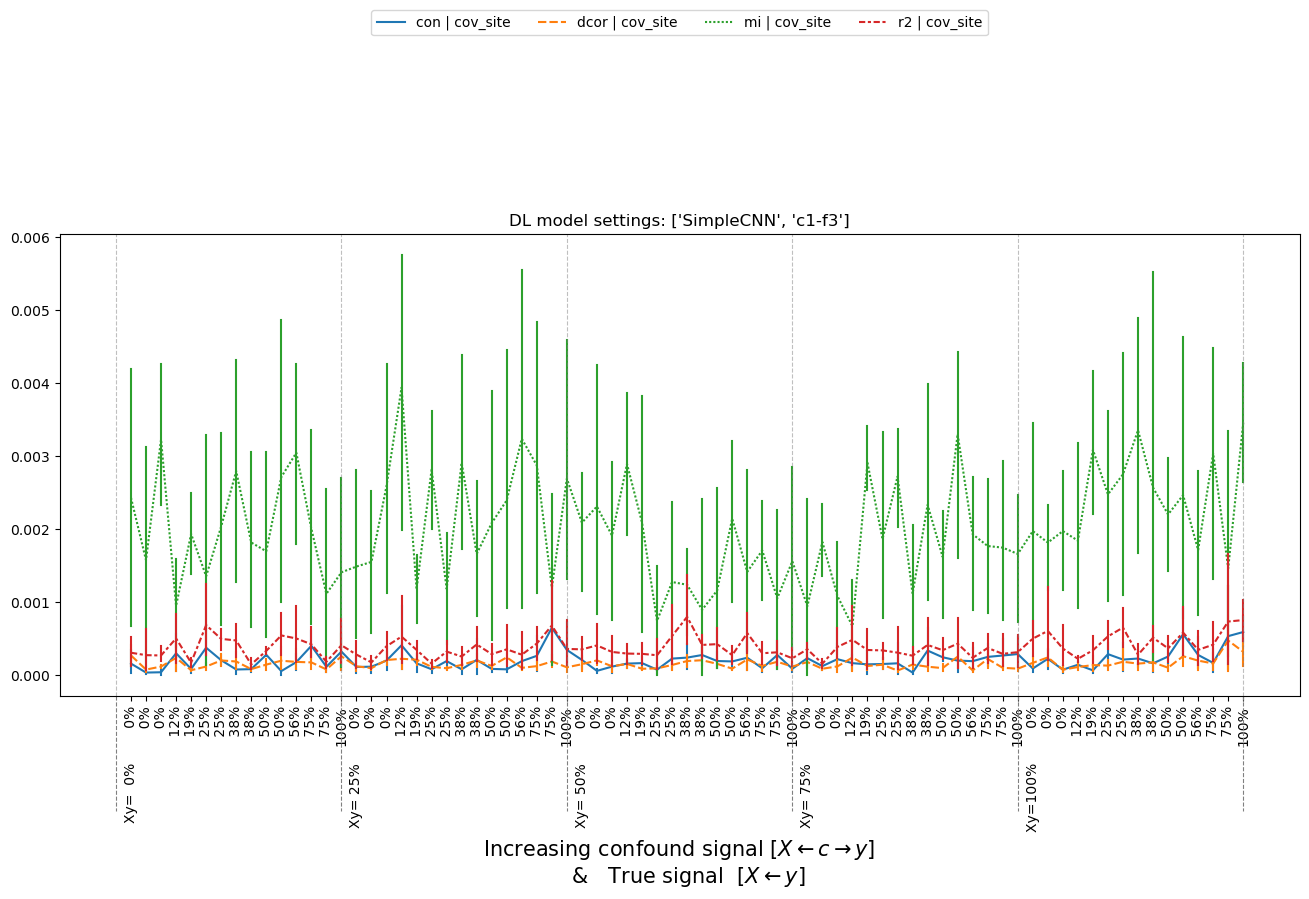

In [ ]:
plot_deeprepviz_results(df_results, filter="(cov_site)")

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


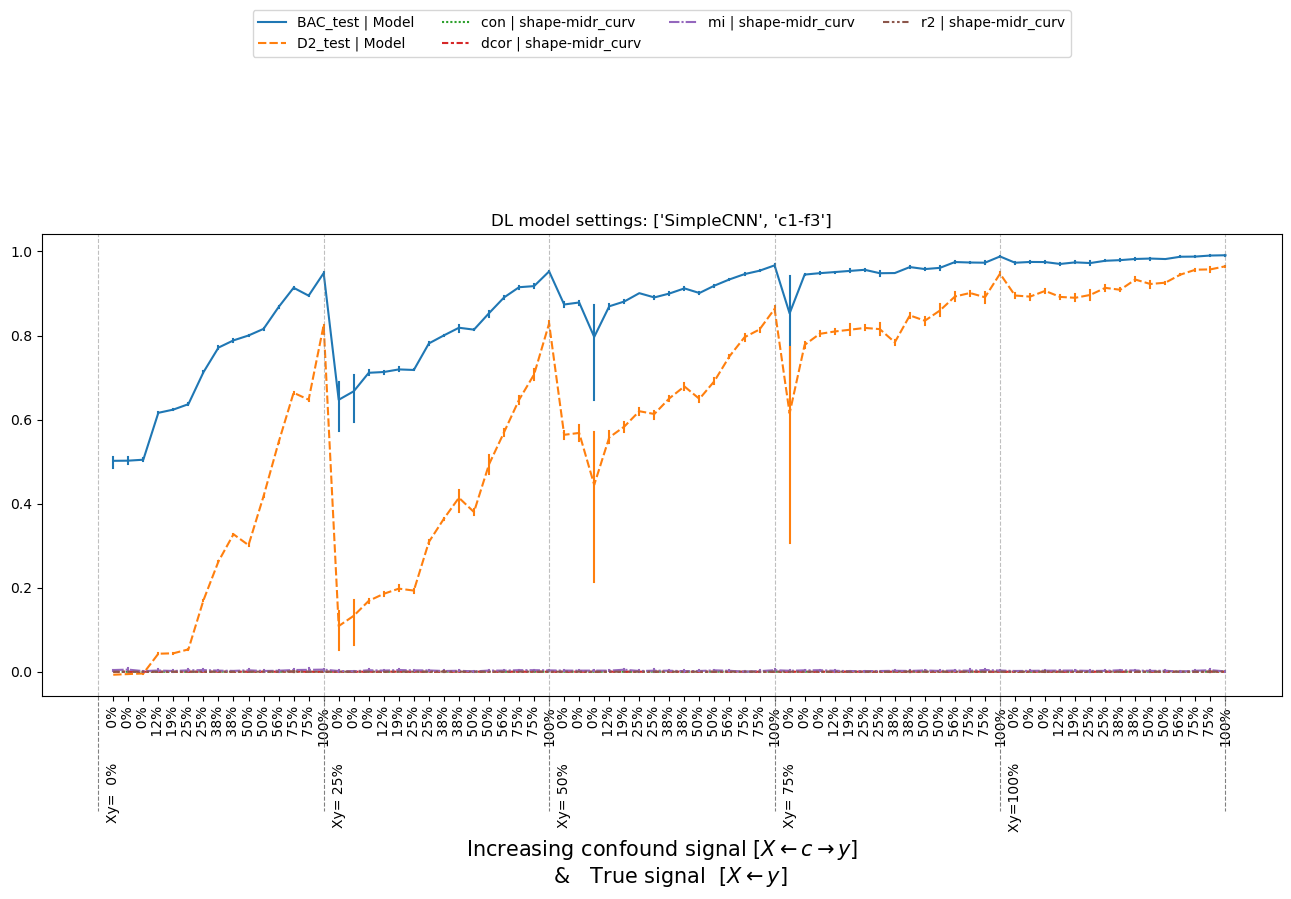

In [ ]:
plot_deeprepviz_results(df_results, filter="(.*_test|shape-midr_curv)")

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


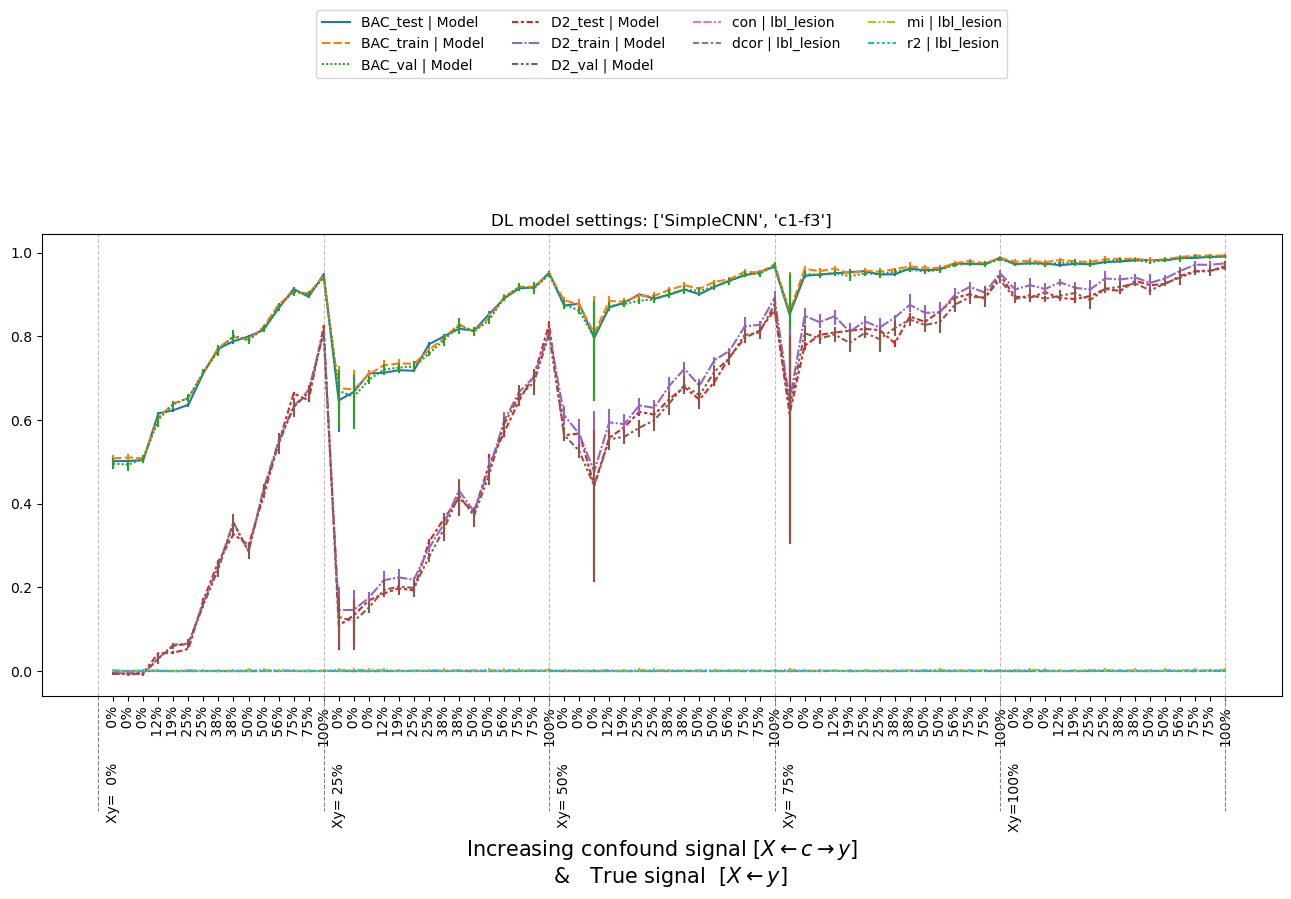

In [ ]:
plot_deeprepviz_results(df_results, filter="(Model|lbl_lesion)")

In [ ]:
# custom_filter = "Model|cov_site" #|lbl_lesion|cov_site|brain-int_fill 
# dfi = df_results.copy()

# # drop the loss
# dfi = dfi.drop(columns=[('Model', 'loss')])
# # flatten the multi-index columns
# dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
# # sort the columns alphabetically
# dfi = dfi.reindex(sorted(dfi.columns), axis=1)
# # drop the costeta columns
# dfi = dfi.filter(regex='^(?!.*costeta)')
# # apply additional user-defined filters
# dfi = dfi.filter(regex=custom_filter)
# dfi = dfi.reset_index(level=0).rename(columns={'level_0': 'DL model settings'})
# # display(dfi)

# # normalize the metric scores
# metric_cols = dfi.columns.str.contains('dcor|mi|con|r2')
# dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
#     lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)

# g = sns.FacetGrid(dfi, row='DL model settings',  margin_titles=True, 
#                   height=3, aspect=2)
# g.map_dataframe(sns.lineplot)
# g.add_legend()  
# # plt.tight_layout()
# plt.show()

### compare 2 model settings

In [ ]:
cy = '*'
cX = 2
yX = 2
logdirs2 = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if 'debug' not in log]
        )))

print("comparing results from n={} model logs:".format(len(logdirs2)))
logdirs2

comparing results from n=5 model logs:


['log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy1-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy2-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy3-cX2-yX2_SimpleCNN_c1-f3',
 'log/toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN_c1-f3']

In [ ]:
df_results2 = collect_deeprepviz_results(logdirs2, print_log=1)
df_results2.style.bar()

  0%|          | 0/5 [00:00<?, ?it/s]

loading logs from: log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX2_SimpleCNN_c1-f3
loading logs from: log/toybrains_n10000_lblmidr-consite_cy1-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading logs from: log/toybrains_n10000_lblmidr-consite_cy3-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading logs from: log/toybrains_n10000_lblmidr-consite_cy2-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading logs from: log/toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN_c1-f3
loading run version: trial_0
loading run version: trial_0
	 lbl_lesion 	=	 0.0000
	 cov_site 	=	 0.0001
	 brain-int_fill 	=	 0.0002
	 shape-midr_curv 	=	 0.0003
	 shape-midr_vol-rad 	=	 0.0002
	 lbl_lesion 	=	 0.0000
	 cov_site 	=	 0.0013
	 brain-int_fill 	=	 0.0031
	 shape-midr_curv 	=	 0.0000
	 shape-midr_vol-rad 	=	 0.0035
	 lbl_lesion 	=	 0.0003
	 cov_site 	=	 0.0007
	 brain-int_fill 	=	 0.0009
	 shape-midr_curv 	=	 0.0004
	 shape-midr_vol-rad 	=	 0.0003
	 lbl_lesion 	=	 -0.7741
	 cov

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


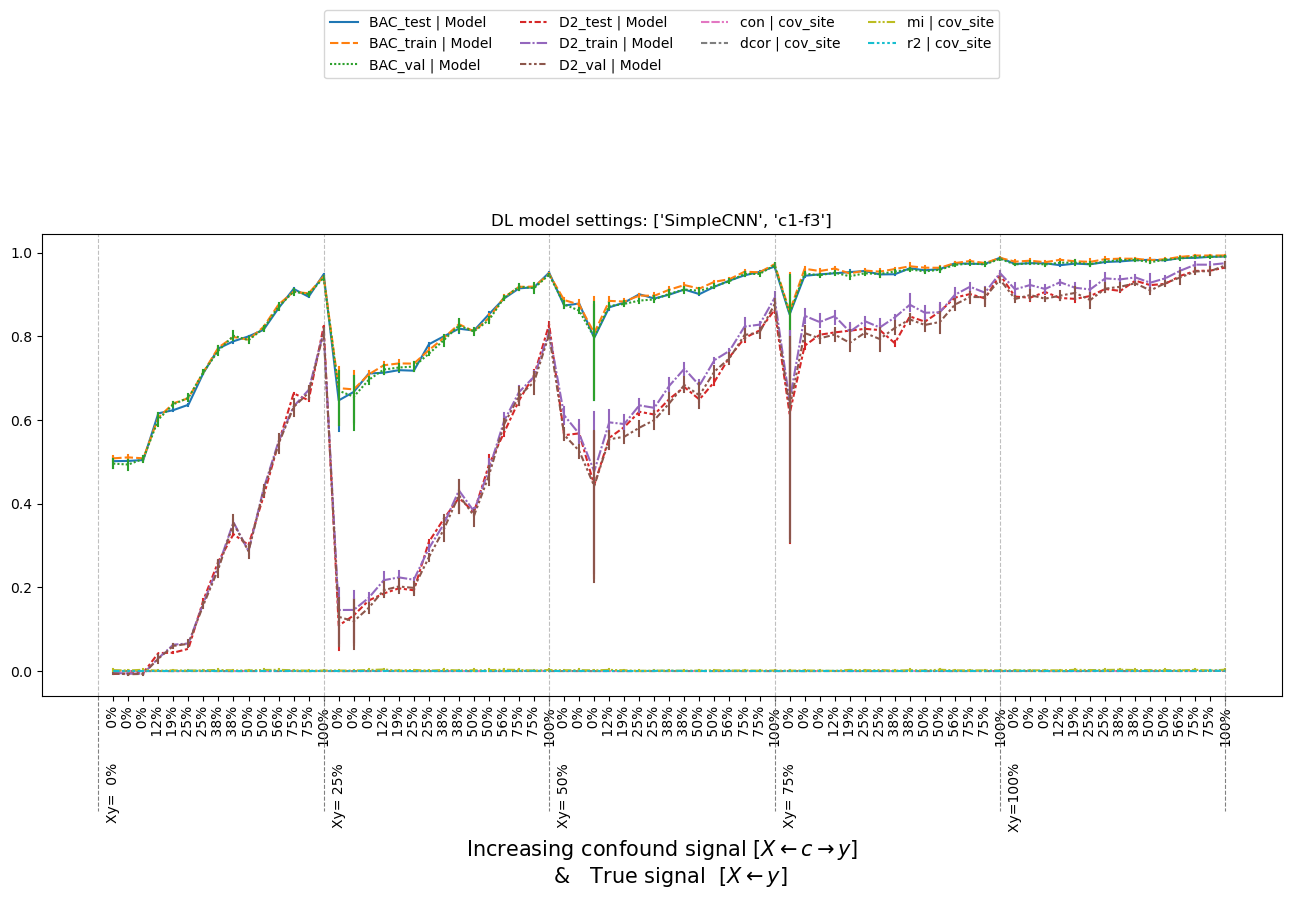

/tmp/ipykernel_1572310/2205771248.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)


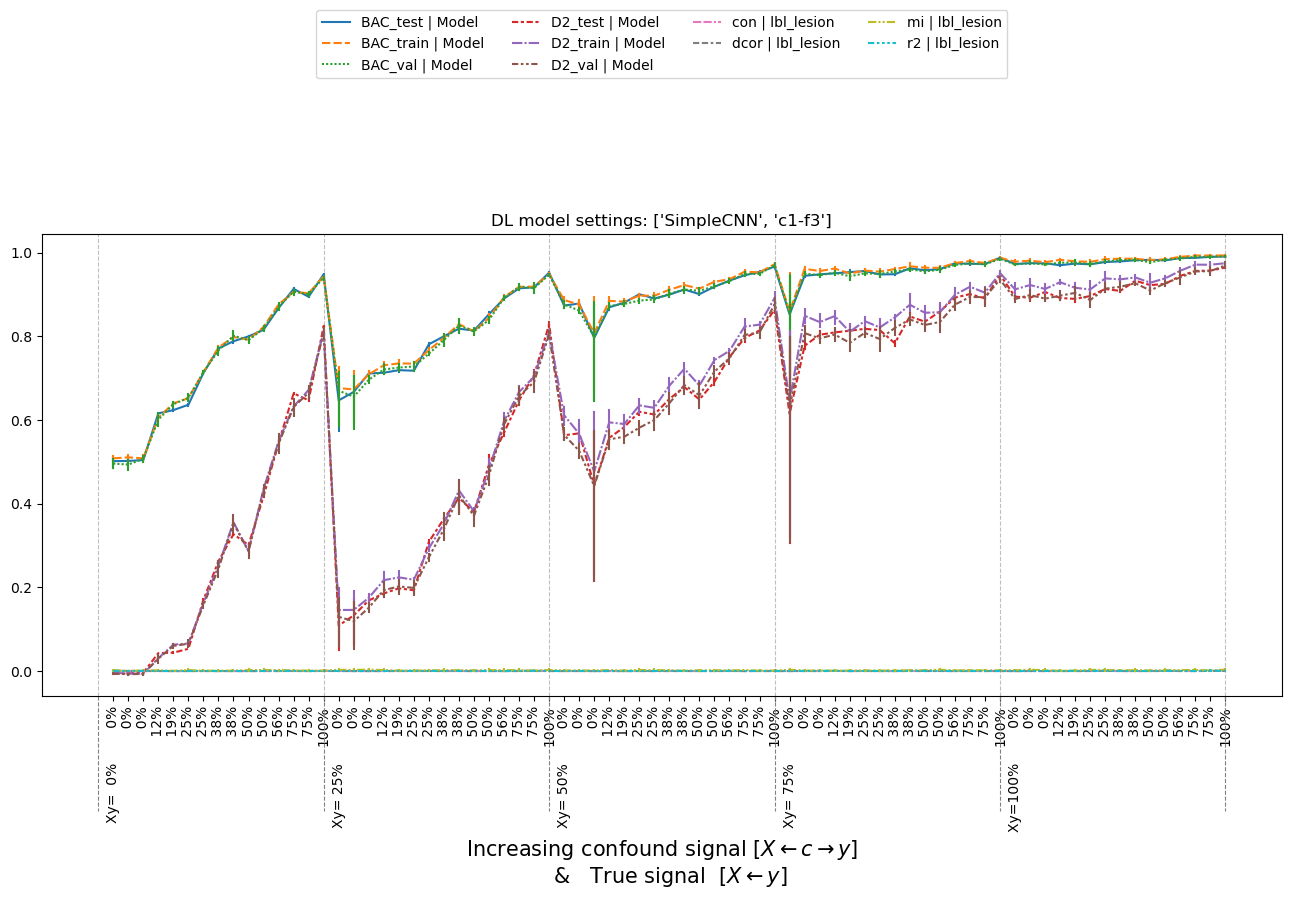

In [ ]:
plot_deeprepviz_results(df_results, filter="(Model|cov_site)")
plot_deeprepviz_results(df_results, filter="(Model|lbl_lesion)")

#### test with a different 3D dimensionality reduction method?

In [ ]:
# dim_reduct_method = TSNE(n_components=3, learning_rate='auto',
#                          init='random', perplexity=3) 

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./log/lightning_logs/
# !kill -9 1237900

#### Calculate other backend metrics ?